https://www.kaggle.com/c/lish-moa/overview

The Connectivity Map, a project within the Broad Institute of MIT and Harvard, together with the Laboratory for Innovation Science at Harvard (LISH), presents this challenge with the goal of advancing drug development through improvements to MoA prediction algorithms.

What is the Mechanism of Action (MoA) of a drug? And why is it important?

In the past, scientists derived drugs from natural products or were inspired by traditional remedies. Very common drugs, such as paracetamol, known in the US as acetaminophen, were put into clinical use decades before the biological mechanisms driving their pharmacological activities were understood. Today, with the advent of more powerful technologies, drug discovery has changed from the serendipitous approaches of the past to a more targeted model based on an understanding of the underlying biological mechanism of a disease. In this new framework, scientists seek to identify a protein target associated with a disease and develop a molecule that can modulate that protein target. As a shorthand to describe the biological activity of a given molecule, scientists assign a label referred to as mechanism-of-action or MoA for short.

How do we determine the MoAs of a new drug?

One approach is to treat a sample of human cells with the drug and then analyze the cellular responses with algorithms that search for similarity to known patterns in large genomic databases, such as libraries of gene expression or cell viability patterns of drugs with known MoAs.

In this competition, you will have access to a unique dataset that combines gene expression and cell viability data. The data is based on a new technology that measures simultaneously (within the same samples) human cells’ responses to drugs in a pool of 100 different cell types (thus solving the problem of identifying ex-ante, which cell types are better suited for a given drug). In addition, you will have access to MoA annotations for more than 5,000 drugs in this dataset.

As is customary, the dataset has been split into testing and training subsets. Hence, your task is to use the training dataset to develop an algorithm that automatically labels each case in the test set as one or more MoA classes. Note that since drugs can have multiple MoA annotations, the task is formally a multi-label classification problem.

How to evaluate the accuracy of a solution?

Based on the MoA annotations, the accuracy of solutions will be evaluated on the average value of the logarithmic loss function applied to each drug-MoA annotation pair.

If successful, you’ll help to develop an algorithm to predict a compound’s MoA given its cellular signature, thus helping scientists advance the drug discovery process.

In [1]:
import gc
import time
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA

import lightgbm as lgb

#Path to save the output
path_analysis = 'C:\\Users\\maxwi\\Python\\Kaggle\\Mechanism of action\\data_analysis\\'

In [2]:
#load the Data
train_features = pd.read_csv('train_features.csv')
train_targets_scored = pd.read_csv('train_targets_scored.csv')
test_features = pd.read_csv('test_features.csv')

In [3]:
#Function to reduce memory usage.
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
train_features = reduce_mem_usage(train_features)
train_targets_scored = reduce_mem_usage(train_targets_scored)
test_features = reduce_mem_usage(test_features)

Mem. usage decreased to 40.18 Mb (74.8% reduction)
Mem. usage decreased to  4.86 Mb (87.1% reduction)
Mem. usage decreased to  6.72 Mb (74.8% reduction)


In [5]:
display(train_features)
print()

#Verify missing.
train_features_missing = pd.DataFrame(train_features.isnull().sum())
print('Quantity of missing values:', train_features_missing[0].sum())

sig_id      cp_type  cp_time cp_dose       g-0       g-1  \
0      id_000644bb2       trt_cp       24      D1  1.061523  0.557617   
1      id_000779bfc       trt_cp       72      D1  0.074280  0.408691   
2      id_000a6266a       trt_cp       48      D1  0.627930  0.581543   
3      id_0015fd391       trt_cp       48      D1 -0.513672 -0.249146   
4      id_001626bd3       trt_cp       72      D2 -0.325439 -0.400879   
...             ...          ...      ...     ...       ...       ...   
23809  id_fffb1ceed       trt_cp       24      D2  0.139404 -0.063599   
23810  id_fffb70c0c       trt_cp       24      D2 -1.326172  0.347900   
23811  id_fffc1c3f4  ctl_vehicle       48      D2  0.394287  0.375488   
23812  id_fffcb9e7c       trt_cp       24      D1  0.666016  0.232422   
23813  id_ffffdd77b       trt_cp       72      D1 -0.859863  1.024414   

            g-2       g-3       g-4       g-5  ...      c-90      c-91  \
0     -0.247925 -0.620605 -0.194458 -1.011719  ...  0.286133  0.258301   
1      0.299072  0.060394  1.018555  0.520508  ... -0.426514  0.754395   
2      1.553711 -0.076416 -0.032288  1.239258  ... -0.725098 -0.629883   
3     -0.265625  0.528809  4.062500 -0.809570  ... -2.099609 -0.644043   
4      0.970215  0.691895  1.417969 -0.824219  ...  0.004200  0.004799   
...         ...       ...       ...       ...  ...       ...       ...   
23809 -0.111206 -0.507812 -0.471191  0.720215  ...  0.196899  0.026199   
23810 -0.374268  0.990723 -0.717773  0.662109  ...  0.428711  0.442627   
23811  0.310791 -0.738770  0.550293 -0.015900  ...  0.541016  0.375488   
23812  0.439209  0.204346  0.853027 -0.034302  ... -0.110474  0.425781   
23813 -0.136108  0.795410 -0.361084 -3.675781  ... -3.388672 -1.745117   

           c-92      c-93      c-94      c-95      c-96      c-97      c-98  \
0      0.807617  0.552246 -0.191162  0.658203 -0.398193  0.213867  0.380127   
1      0.470703  0.022995  0.295654  0.489990  0.152222  0.124084  0.607910   
2      0.610352  0.022293 -1.324219 -0.317383 -0.641602 -0.218750 -1.408203   
3     -5.628906 -1.377930 -0.863281 -1.288086 -1.621094 -0.878418 -0.387695   
4      0.666992  1.069336  0.552246 -0.302979  0.109375  0.288574 -0.378662   
...         ...       ...       ...       ...       ...       ...       ...   
23809 -0.812012  0.343506  0.537109 -0.324707  0.063110  0.916992  0.525879   
23810  0.042297 -0.319580 -0.808594 -0.979980 -0.208374 -0.122375 -0.271484   
23811  0.734375  0.280762  0.411621  0.642090  0.225586  0.759277  0.665527   
23812 -0.201172  0.150635  1.523438  0.709961  0.173218  0.701660 -0.628906   
23813 -6.628906 -4.093750 -7.386719 -1.416016 -3.576172 -0.477539 -2.150391   

           c-99  
0      0.417480  
1      0.737305  
2      0.692871  
3     -0.815430  
4      0.712402  
...         ...  
23809  0.468018  
23810  0.368896  
23811  0.380859  
23812  0.073975  
23813 -4.253906  

[23814 rows x 876 columns]


Quantity of missing values: 0


It is a good news that we don't have any missing values.\
On the other hand, we don't have even 25 thousands of observations to work with.

In [6]:
display(train_targets_scored)
print()

#Verify missing.
train_targets_scored_missing = pd.DataFrame(train_targets_scored.isnull().sum())
print('Quantity of missing values:', train_targets_scored_missing[0].sum())

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0      id_000644bb2                            0                       0   
1      id_000779bfc                            0                       0   
2      id_000a6266a                            0                       0   
3      id_0015fd391                            0                       0   
4      id_001626bd3                            0                       0   
...             ...                          ...                     ...   
23809  id_fffb1ceed                            0                       0   
23810  id_fffb70c0c                            0                       0   
23811  id_fffc1c3f4                            0                       0   
23812  id_fffcb9e7c                            0                       0   
23813  id_ffffdd77b                            0                       0   

       acat_inhibitor  acetylcholine_receptor_agonist  \
0                   0                               0   
1                   0                               0   
2                   0                               0   
3                   0                               0   
4                   0                               0   
...               ...                             ...   
23809               0                               0   
23810               0                               0   
23811               0                               0   
23812               0                               0   
23813               0                               0   

       acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                      0                               0   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               0   
...                                  ...                             ...   
23809                                  0                               0   
23810                                  0                               0   
23811                                  0                               0   
23812                                  0                               0   
23813                                  0                               0   

       adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   
...                           ...                            ...   
23809                           0                              0   
23810                           0                              0   
23811                           0                              0   
23812                           0                              0   
23813                           0                              0   

       adenylyl_cyclase_activator  ...  tropomyosin_receptor_kinase_inhibitor  \
0                               0  ...                                      0   
1                               0  ...                                      0   
2                               0  ...                                      0   
3                               0  ...                                      0   
4                               0  ...                                      0   
...                           ...  ...                                    ...   
23809                           0  ...                                      0   
23810                           0  ..


Quantity of missing values: 0


Again, it is a good news that we don't have any missing values, so we do not need to worry if a missing means no information or just another '0'.

In [7]:
display(test_features)
print()

#Verify missing.
test_features_missing = pd.DataFrame(test_features.isnull().sum())
print('Quantity of missing values:', test_features_missing[0].sum())

sig_id      cp_type  cp_time cp_dose       g-0       g-1  \
0     id_0004d9e33       trt_cp       24      D1 -0.545898  0.130615   
1     id_001897cda       trt_cp       72      D1 -0.182861  0.232056   
2     id_002429b5b  ctl_vehicle       24      D1  0.185181 -0.140381   
3     id_00276f245       trt_cp       24      D2  0.482910  0.195557   
4     id_0027f1083       trt_cp       48      D1 -0.397949 -1.267578   
...            ...          ...      ...     ...       ...       ...   
3977  id_ff7004b87       trt_cp       24      D1  0.457031 -0.574219   
3978  id_ff925dd0d       trt_cp       24      D1 -0.588379 -0.254883   
3979  id_ffb710450       trt_cp       72      D1 -0.398438 -0.155396   
3980  id_ffbb869f2       trt_cp       48      D2 -1.095703 -1.775391   
3981  id_ffd5800b6       trt_cp       72      D1 -0.517578  0.295410   

           g-2       g-3       g-4       g-5  ...      c-90      c-91  \
0    -0.513672  0.440918  1.549805 -0.164429  ...  0.098083  0.797852   
1     1.208008 -0.452148 -0.365234 -0.331787  ... -0.119019 -0.185181   
2    -0.391113  0.130981 -1.438477  0.245483  ... -0.226074  0.336914   
3     0.382568  0.424316 -0.585449 -1.202148  ...  0.125977  0.156982   
4     1.913086  0.205688 -0.586426 -0.016602  ...  0.496582  0.757812   
...        ...       ...       ...       ...  ...       ...       ...   
3977  3.392578 -0.620117  0.855469  1.624023  ... -1.178711 -0.642090   
3978  2.585938  0.345703  0.440186  0.310791  ...  0.020996  0.578125   
3979  0.267578 -0.681152  0.015198  0.479004  ...  0.441895  0.915527   
3980 -0.397705  1.015625 -1.334961 -0.220703  ...  0.307861 -0.447266   
3981  0.328613 -0.042786 -0.080017  0.870117  ...  0.036285  0.170776   

          c-92      c-93      c-94      c-95      c-96      c-97      c-98  \
0    -0.142944 -0.206665 -0.230347 -0.119324  0.020996 -0.050201  0.151001   
1    -1.031250 -1.367188 -0.368896 -0.538086  0.035889 -0.476318 -1.380859   
2    -1.383789  0.860352 -1.953125 -1.013672  0.866211  1.015625  0.492432   
3    -0.178345 -1.120117 -0.432617 -0.900391  0.812988 -0.130493  0.564453   
4    -0.157959  1.050781  0.574219  1.089844 -0.296143 -0.531250  0.993164   
...        ...       ...       ...       ...       ...       ...       ...   
3977 -0.436768  0.015900 -0.653809 -0.479004 -1.267578 -1.127930 -0.416748   
3978 -0.588867  0.805664  0.931152  1.273438  0.261475 -0.279053 -0.013100   
3979 -0.186157  0.404785  0.957031  0.466553  0.046112  0.588867 -0.420410   
3980 -0.819336  0.778320  0.313232  0.128540 -0.261719  0.507324  0.743164   
3981  0.593750 -0.050690  0.281006 -0.404053 -0.494873  0.075684 -0.135620   

          c-99  
0    -0.774902  
1    -0.729980  
2    -0.194214  
3    -0.581055  
4     1.837891  
...        ...  
3977 -0.660156  
3978 -0.093384  
3979 -0.150391  
3980 -0.048401  
3981  0.527832  

[3982 rows x 876 columns]


Quantity of missing values: 0


Our train and test file are in the same format with the same variables. There is no problem here.

Our train_features and train_targets_scored are already in the same order, so we won't have any problem at modeling. We do not need to loose time joining the tables.

We can see that we have 206 different Mechanisms of Action. One approach is to run 206 different LightGBM.\
The downside of this approach is time. However, in the 'lightgbm test' notebook, we could see that this methodology can be donne in less tha 9 hours (our limit to run this model in Kaggle's notebook). 

If we have time, we will try a Feedforward neuron network also. 

In [8]:
'''
Before start studying the variables, lets separate train_features and train_targets_scored into train_set and validation_set.
This is important to avoid overfitting.
'''
train_features_set, validation_features_set = train_test_split(train_features, test_size = 0.2, random_state = 1).copy()

train_labels_set = train_targets_scored.iloc[train_features_set.index].copy()
validation_labels_set = train_targets_scored.iloc[validation_features_set.index].copy()

#reset index. We don't really need a index as a number. We can identify our observations by the column 'sig_id'
train_features_set.reset_index(inplace = True)
train_features_set.drop('index', axis = 1, inplace = True)

validation_features_set.reset_index(inplace = True)
validation_features_set.drop('index', axis = 1, inplace = True)

train_labels_set.reset_index(inplace = True)
train_labels_set.drop('index', axis = 1, inplace = True)

validation_labels_set.reset_index(inplace = True)
validation_labels_set.drop('index', axis = 1, inplace = True)

C:\Users\maxwi\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
#It looks like we have a lot of variables g-x and c-x.
#Lets first verify the names of our variables.
features_df = pd.DataFrame(train_features_set.columns)
features_df['first_2_letter'] = features_df[0].str.extract(r"(.{2})", expand = True)
features_df['first_2_letter'].value_counts()

g-    772
c-    100
cp      3
si      1
Name: first_2_letter, dtype: int64

As we can see, we have 772 gene expression variables (g), and 100 cell viability variables (c).\
The 3 'cp' are cp_type, cp_time, and cp_dose.

cp_type indicates if the person was in the treated group (cp_vehicle) or in the control group. Drugs in the control group (ctrl_vehicle) does not have any  Mechanism of Action.

cp_time indicate the treatment duration  (24, 48, 72 hours).

cp_dose indicates the dose (high or low, D1 or D2).


It would be very helpfull if we had information about how the dose and treatment duration affect the 'g' and 'c' variables and the mechanism of action. For example, given that we already have the 'g' and 'c' variables, does it really matter the dosage and the duration? Does a high dosage imply that the 'g' and 'c' variables will have a bigger impact in the pacient so the mechanism of action will be different.\
To solve this problem we can design new variable, e. g., multiply all 'g' and 'c' variables by 2 when we have a high dosage, or make differents models by dosage and treatment duration.
Given that we do not even know if high dosage is D1, as it looks like by the way they described the variable, or D2, as one could infer that D1 mens one dosage and D2 means 2 dosages, it is preferable to do differents models. Nonetheless, we only have 24k observations, so if we won't have a good number of observations to make so many models.

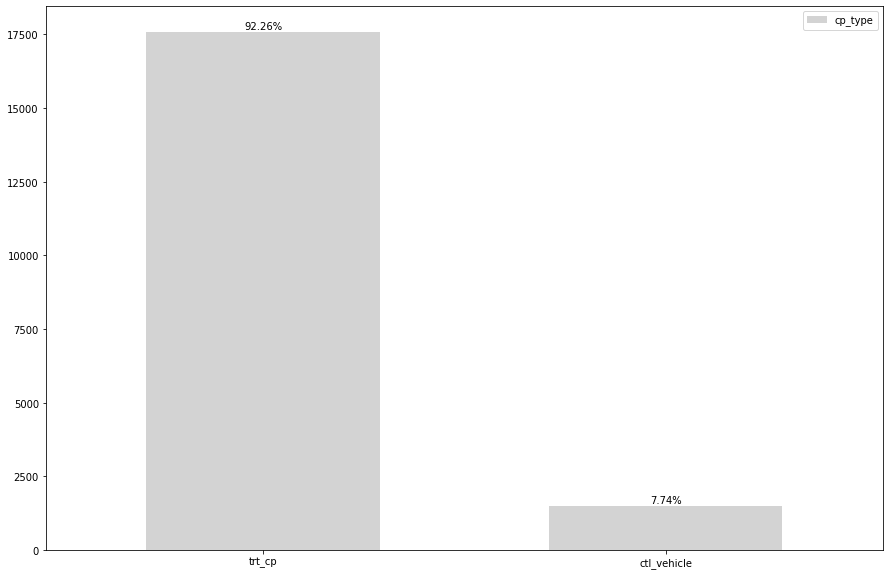

In [10]:
#Lets see the variable cp_type
train_features_cp_type_bar_graph = pd.DataFrame(train_features_set['cp_type'].value_counts())

ax = train_features_cp_type_bar_graph.plot(kind='bar', figsize=(15,10), width = 0.58, rot = 0,
                                           align='center', color = 'LightGray', edgecolor = None)

total = 0
for bars in ax.patches:
    total += bars.get_height()

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height/total:.2%}', (x + width/2, y + 100 + height), ha = 'center')

Almost 8% of our observations are from the control group. 
We should withdraw these observations from our database to train our model. However, we must put a flag in our model to classify all MoA as zero when classifying a control observation. 

In [11]:
#Nonetheless, lets verify if the control group really has no MoA.
#first, lets sum how many MoAs each observations has.
train_labels_set['sum_MoA'] = train_labels_set.drop(['sig_id'], axis = 1).astype(bool).sum(axis = 1)
#Now, we sum the total MoA of each obsevartion in control
train_labels_set[train_features_set['cp_type'] == 'ctl_vehicle']['sum_MoA'].sum()

0

In [12]:
#Lets see if, despite having no MoA, the control group has value for the other variables.
train_features_set[train_features_set['cp_type'] == 'ctl_vehicle']

sig_id      cp_type  cp_time cp_dose       g-0       g-1  \
29     id_189f13f21  ctl_vehicle       24      D2  0.562500  0.005901   
43     id_427837c64  ctl_vehicle       48      D1  0.249023 -1.678711   
74     id_456f3d5b3  ctl_vehicle       48      D1  0.301270 -0.444336   
98     id_9413d5f6e  ctl_vehicle       24      D2  1.265625  0.759277   
113    id_9d73601e2  ctl_vehicle       72      D1 -1.004883 -2.048828   
...             ...          ...      ...     ...       ...       ...   
18996  id_66ea73036  ctl_vehicle       24      D2 -1.074219 -1.411133   
19003  id_89de5fe36  ctl_vehicle       72      D2 -1.058594  1.289062   
19018  id_2f621ce6a  ctl_vehicle       48      D1 -0.247803  0.373779   
19028  id_f62f071cf  ctl_vehicle       72      D1 -0.162964 -1.331055   
19037  id_2528aa355  ctl_vehicle       24      D1 -1.228516 -0.820312   

            g-2       g-3       g-4       g-5  ...      c-90      c-91  \
29     2.087891  0.891602 -1.762695  0.548828  ...  0.951660  0.508301   
43    -1.261719  0.504395 -0.596680 -0.131958  ...  0.749023 -0.233154   
74    -0.674316 -0.235962  0.780273  0.047485  ...  0.782715  1.655273   
98     0.776855 -0.561523  1.117188 -1.480469  ...  0.054199 -2.222656   
113    0.244629  1.050781 -2.101562  0.699219  ...  1.112305  0.742188   
...         ...       ...       ...       ...  ...       ...       ...   
18996  0.768555  1.193359 -2.017578  0.150513  ...  0.044098  0.909668   
19003 -2.513672  0.035004  0.073914 -2.720703  ... -0.422363 -0.843750   
19018  0.335938 -0.778809  0.576660  0.564453  ...  0.309326  0.014603   
19028  0.397705  0.002800  0.077393  0.649902  ...  0.436523 -0.032898   
19037  0.001600  1.156250 -0.512695 -0.326416  ...  1.649414 -0.062622   

           c-92      c-93      c-94      c-95      c-96      c-97      c-98  \
29    -0.434326  0.019302 -0.042786  0.063416 -0.349121 -0.224609 -0.801270   
43     1.429688  1.796875  2.382812  0.637207  0.621094  0.719727  0.910156   
74     1.051758  0.909668  0.351074  0.325684  0.826660  0.688477  1.566406   
98     0.505371  0.270996 -0.144165  0.219727 -0.963867  0.668457  0.149780   
113   -0.464355  1.641602  1.283203  1.154297  1.137695  1.161133  1.315430   
...         ...       ...       ...       ...       ...       ...       ...   
18996 -1.275391 -0.598633 -0.194336 -0.594727 -0.326172 -0.275146 -0.032898   
19003  0.484619 -1.016602 -0.108582  0.079224  0.070618 -0.157593 -1.658203   
19018  0.397217  0.319580  0.385498 -0.596680 -0.381592  0.431641  1.170898   
19028 -0.288086  0.278076  0.576660  0.201782 -0.025208 -0.025803  0.954102   
19037 -0.582520  0.951172  0.260986 -0.230957  0.650391  0.673340  0.513672   

           c-99  
29     0.933105  
43     1.129883  
74     1.136719  
98    -0.520508  
113    0.785156  
...         ...  
18996  0.662598  
19003 -1.101562  
19018  0.548828  
19028  0.733398  
19037  1.282227  

[1475 rows x 876 columns]

This shows us that it may be important to remove these observations for our training. \
If we keep these observations, we only have more observations with no information or, even worst, a lot of observation with misleading informations since we do not know if the 'g' and 'c' variables represents a drug with no effect in the human body or the original drug.\
However, to have sure about our decision we must study the distributions of the variables in the control and treatment group.\
If there are no change in the distribution of variables between control and treatment, it is crucial to remove the control group from our train dataset.

In [34]:
# Remove control observations.
train_features_without_control = train_features_set[train_features_set['cp_type'] != 'ctl_vehicle'].copy()
train_labels_without_control = train_labels_set.iloc[train_features_without_control.index].copy()
print('Observations left to train our model:', len(train_features_without_control))

# Only control observations.
train_features_only_control = train_features_set[train_features_set['cp_type'] == 'ctl_vehicle'].copy()
train_labels_only_control = train_labels_set.iloc[train_features_only_control.index].copy()

#reset index. 
train_features_without_control.reset_index(inplace = True)
train_features_without_control.drop('index', axis = 1, inplace = True)

train_labels_without_control.reset_index(inplace = True)
train_labels_without_control.drop('index', axis = 1, inplace = True)

train_features_without_control.reset_index(inplace = True)
train_features_without_control.drop('index', axis = 1, inplace = True)

train_labels_only_control.reset_index(inplace = True)
train_labels_only_control.drop('index', axis = 1, inplace = True)

Observations left to train our model: 17576


In [14]:
'''
For the validation and test, we will remove just the column 'cp_type'.
However, we will not delete the observations. 
Instead, we will create a separate data frame with 'cp_type' so we can set all MoA equal to zero for these observations.
'''

validation_features_without_control = validation_features_set.drop(['cp_type'], axis = 1).copy()
validation_features_control = validation_features_set[['sig_id', 'cp_type']].copy()

test_features_without_control = test_features.drop(['cp_type'], axis = 1).copy()
test_features_control = test_features[['sig_id', 'cp_type']].copy()

For now, to continue our data study and train our model, we should use \
train_features_without_control, and\
train_labels_without_control

To do the hyperparametrization and the holdout, we should use\
validation_features_without_control and validation_features_control, and\
test_features_without_control and test_features_control

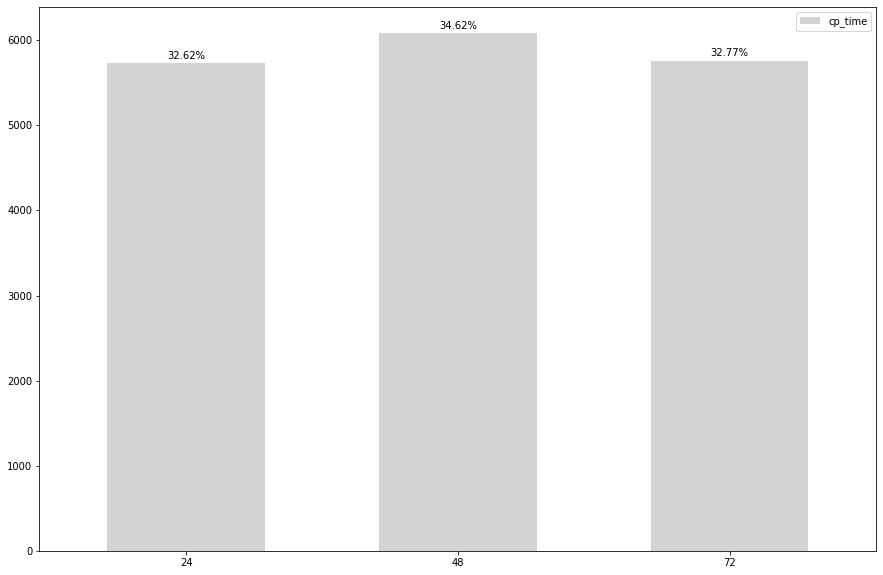

In [15]:
#Now, lets study the variable cp_time
train_features_cp_time_bar_graph = pd.DataFrame(train_features_without_control['cp_time'].value_counts()).sort_index()

ax = train_features_cp_time_bar_graph.plot(kind='bar', figsize=(15,10), width = 0.58, rot = 0,
                                           align = 'center', color = 'LightGray', edgecolor = None)

total = 0
for bars in ax.patches:
    total += bars.get_height()

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height/total:.2%}', (x + width/2, y + 50 + height), ha = 'center')

The duration of each treatment is well distributed in our data.
Lets verify if treatments with longer durations presents more MoA.

In [16]:
#Compute value_counts just to see how many bins we should plot at the histogram.
train_labels_without_control_cp_time_hist_24 = train_labels_without_control[train_features_without_control['cp_time'] == 24]['sum_MoA'].value_counts().sort_index()
train_labels_without_control_cp_time_hist_24

0    1933
1    3288
2     415
3      79
4      13
5       3
7       2
Name: sum_MoA, dtype: int64

In [17]:
train_labels_without_control_cp_time_hist_48 = train_labels_without_control[train_features_without_control['cp_time'] == 48]['sum_MoA'].value_counts().sort_index()
train_labels_without_control_cp_time_hist_48

0    2094
1    3462
2     423
3      83
4      16
5       4
7       2
Name: sum_MoA, dtype: int64

In [18]:
train_labels_without_control_cp_time_hist_72 = train_labels_without_control[train_features_without_control['cp_time'] == 72]['sum_MoA'].value_counts().sort_index()
train_labels_without_control_cp_time_hist_72

0    1978
1    3259
2     419
3      84
4      14
5       3
7       2
Name: sum_MoA, dtype: int64

A drug can have from none to 7 different mechanisms of action.
For some reason, we do not have any observation with 6 MoA.
After, when we train out model, we can considerer that drugs have a limited number of mechanisms of action and, for example, consider only the 10 most probables mechanisms.

(0.0, 0.6)

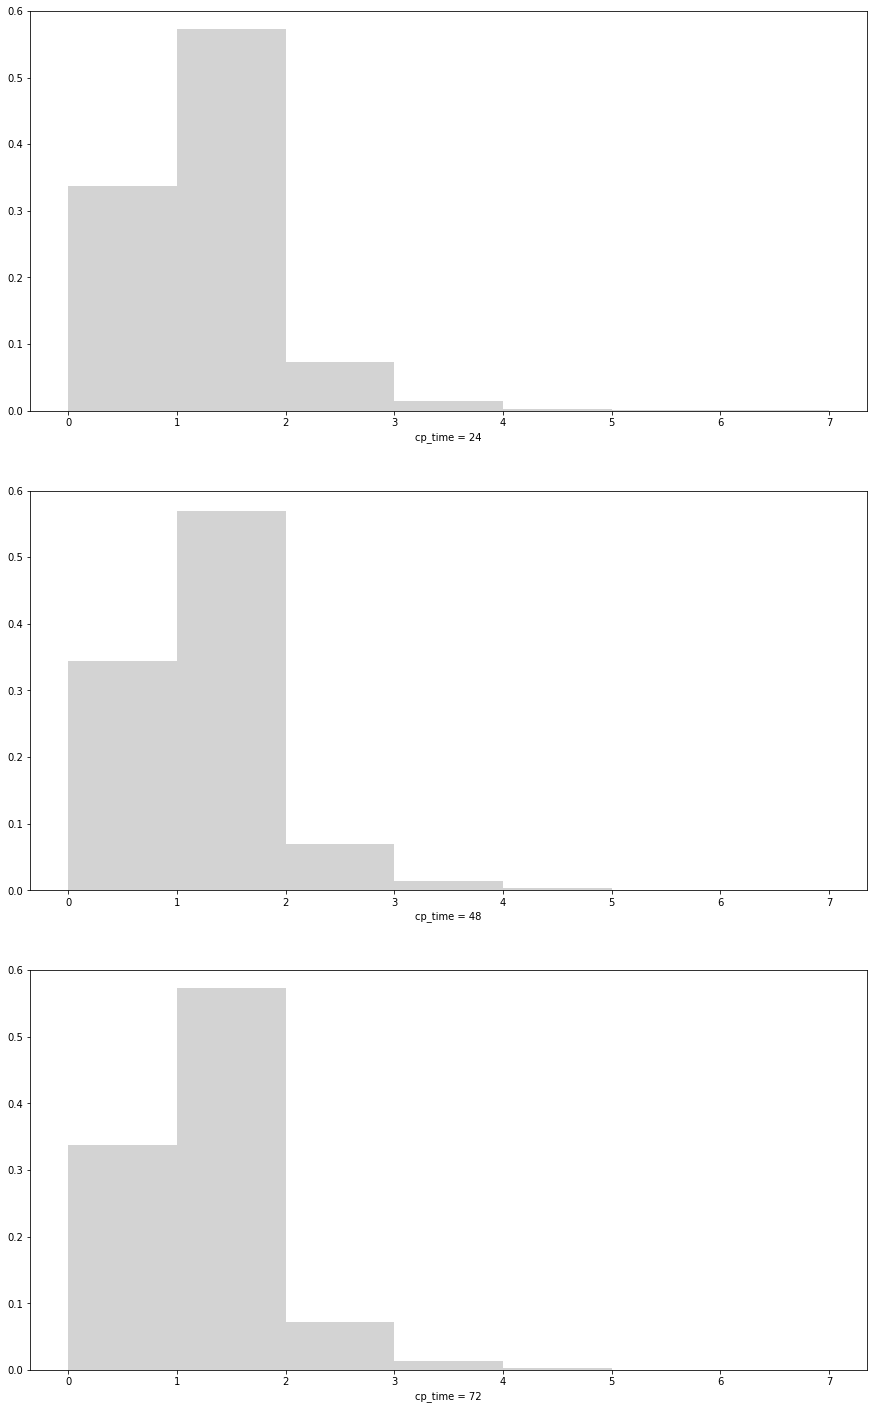

In [19]:
#Lets transform these tables in histograns to make it easier to the eyes.
fig = plt.figure(figsize=(15,25))

ax1 = fig.add_subplot(3,1,1)
ax1 = train_labels_without_control[train_features_without_control['cp_time'] == 24]['sum_MoA'].hist(density = True,
                histtype = 'bar', bins = 7, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('cp_time = 24')
plt.ylim(top=0.6)

ax2 = fig.add_subplot(3,1,2)
ax2 = train_labels_without_control[train_features_without_control['cp_time'] == 48]['sum_MoA'].hist(density = True,
                histtype = 'bar', bins = 7, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('cp_time = 48')
plt.ylim(top=0.6)

ax3 = fig.add_subplot(3,1,3)
ax3 = train_labels_without_control[train_features_without_control['cp_time'] == 24]['sum_MoA'].hist(density = True,
                histtype = 'bar', bins = 7, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('cp_time = 72')
plt.ylim(top=0.6)

As we can see, the number of mechanisms of action does not change according the duration of the treatment.

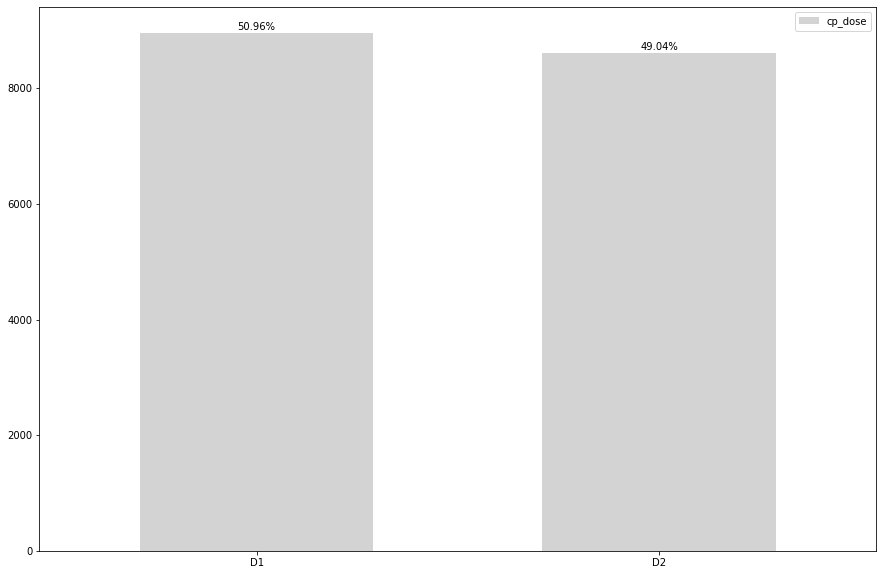

In [20]:
#Study of the variable cp_dose
train_features_cp_dose_bar_graph = pd.DataFrame(train_features_without_control['cp_dose'].value_counts()).sort_index()

ax = train_features_cp_dose_bar_graph.plot(kind='bar', figsize=(15,10), width = 0.58, rot = 0,
                                           align = 'center', color = 'LightGray', edgecolor = None)

total = 0
for bars in ax.patches:
    total += bars.get_height()

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height/total:.2%}', (x + width/2, y + 50 + height), ha = 'center')

Histogram:


(0.0, 0.6)

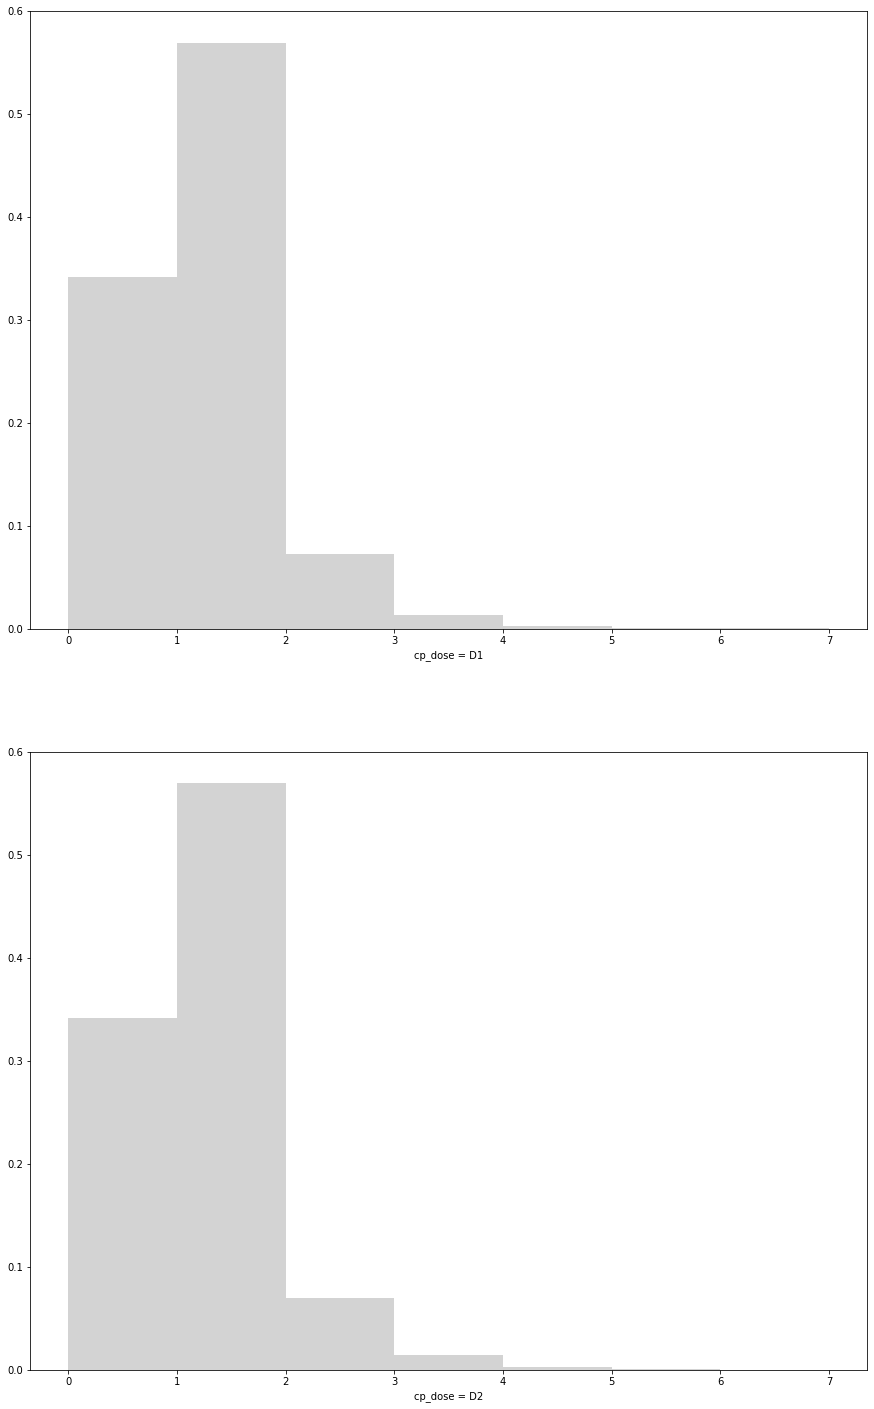

In [21]:
#Our data is well balanced in relation to drug dosage.
#Lets see if the number of MoA is equilibrated too.
print('Histogram:')
fig = plt.figure(figsize=(15,25))

ax1 = fig.add_subplot(2,1,1)
ax1 = train_labels_without_control[train_features_without_control['cp_dose'] == 'D1']['sum_MoA'].hist(density = True,
                histtype = 'bar', bins = 7, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('cp_dose = D1')
plt.ylim(top=0.6)

ax2 = fig.add_subplot(2,1,2)
ax2 = train_labels_without_control[train_features_without_control['cp_dose'] == 'D2']['sum_MoA'].hist(density = True,
                histtype = 'bar', bins = 7, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('cp_dose = D2')
plt.ylim(top=0.6)

In [22]:
#Lets see if the realation between cp_time and cp_dose is equilibrated too.
train_cp_time_cp_dose_sunburst = train_features_without_control.groupby(['cp_time', 'cp_dose'])['sig_id'].count().reset_index()
train_cp_time_cp_dose_sunburst.columns = ['cp_time', 'cp_dose', 'count']

fig = px.sunburst(
    train_cp_time_cp_dose_sunburst,
    path = ['cp_time','cp_dose'],
    values = 'count',
    title = 'Sunburst chart: cp_time, cp_dose',
    color = 'count', color_continuous_scale = 'Blues',
)

fig.update_traces(go.Sunburst(textinfo= 'label + percent entry'))
    
fig.show()


In [23]:
#Another way to see the same information is with a tree map
fig =px.treemap(
    train_cp_time_cp_dose_sunburst,
    path = ['cp_dose', 'cp_time'],
    values = 'count',
    title = 'Tree map: cp_time, cp_dose',
    color = 'count', color_continuous_scale = 'Blues',
)

fig.update_layout(template = 'seaborn')
fig.data[0].textinfo = 'label + percent entry'
fig.show()

We can notice that all groups of treatment duration and drug dosage have the same proportion in our database.
The segment (D1, 48) have a little more participation, but a difference of only 2% does not seen to be relevant enouth to treat it diferently from the other segments.\
If we decide to do one model by dosage and duration, we will have only 2812 (17576*0.16) to work with in each model.

All the other variables(772 gene expression variables and 100 cell viability variables) are continuous variables and there isn't much to analize. We already know that there isn't any missing in our database, but we can also see if any of these variables is actually a constant (what would not be usefull for modeling).\
It is also interisting to see the correlations among 'g' variables and the correlations amog the 'c' variables. If they are highly correlated, we can perform a principal component analysis. This will allow our model to be more efficint, especially considering the small number of observations that we have.

Describe the standard deviation of g and c variables:


count    872.000000
mean       1.294696
std        0.373706
min        0.576172
25%        1.029053
50%        1.196777
75%        1.448730
max        2.390625
Name: std, dtype: float64


Histogram:


(0.0, 2)

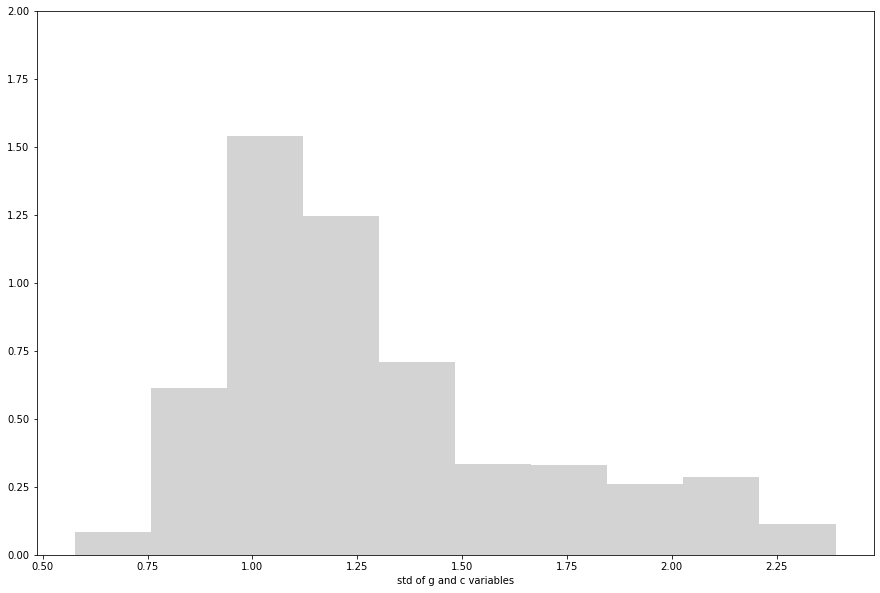

In [24]:
#Computing the standard deviation for 'g_' and 'c_' variables.
describe_g_c_variables = train_features_without_control.drop(['cp_time'], axis = 1).describe()
std_g_c = describe_g_c_variables.iloc[2]
print('Describe the standard deviation of g and c variables:')
display(std_g_c.describe())
print()

#Histogram
print('Histogram:')
fig = plt.figure(figsize=(15,10))

ax = std_g_c.hist(density = True,
                histtype = 'bar', bins = 10, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('std of g and c variables')
plt.ylim(top = 2)

We can see that some variables have much more variance than others. Probably, these variables will be more important in the model. However, we do not have any variable without variance.

Lets repeat this study but separating the g variables from the c ones.

Describe the standard deviation of g variables:


count    772.000000
mean       1.208584
std        0.290972
min        0.576172
25%        1.009521
50%        1.151367
75%        1.336182
max        2.330078
Name: std, dtype: float64


Histogram:


(0.0, 2.5)

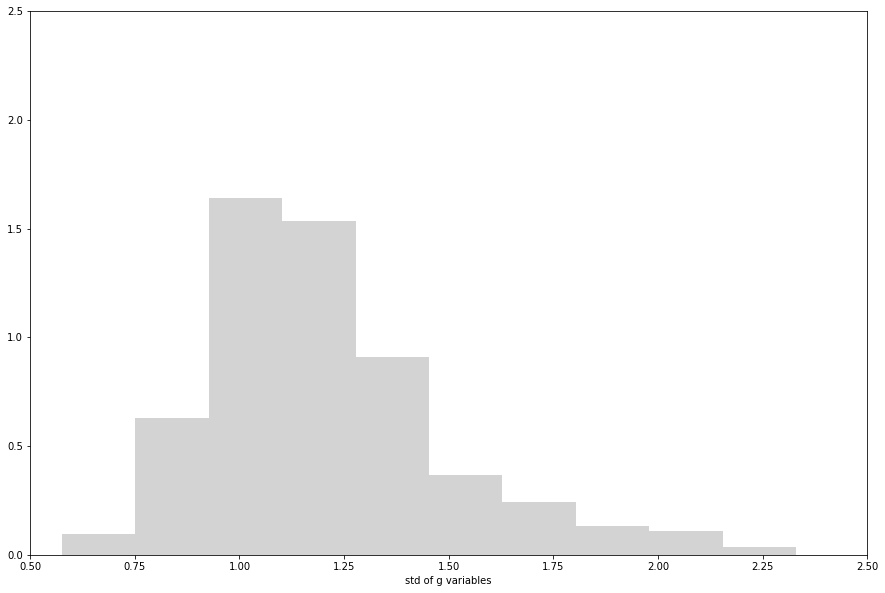

In [25]:
#Computing the standard deviation for 'g_' variables.
mask_g = train_features_without_control.columns.str.contains('^g-*')

describe_g_variables = train_features_without_control.loc[:,mask_g].describe()
std_g = describe_g_variables.iloc[2]
print('Describe the standard deviation of g variables:')
display(std_g.describe())
print()

#Histogram
print('Histogram:')
fig = plt.figure(figsize=(15,10))

ax = std_g.hist(density = True,
                histtype = 'bar', bins = 10, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('std of g variables')
plt.xlim(left = 0.5, right = 2.5)
plt.ylim(top = 2.5)

Describe the standard deviation of c variables:


count    100.000000
mean       1.959482
std        0.255153
min        1.059570
25%        1.817627
50%        2.020508
75%        2.121094
max        2.390625
Name: std, dtype: float64


Histogram:


(0.0, 2.5)

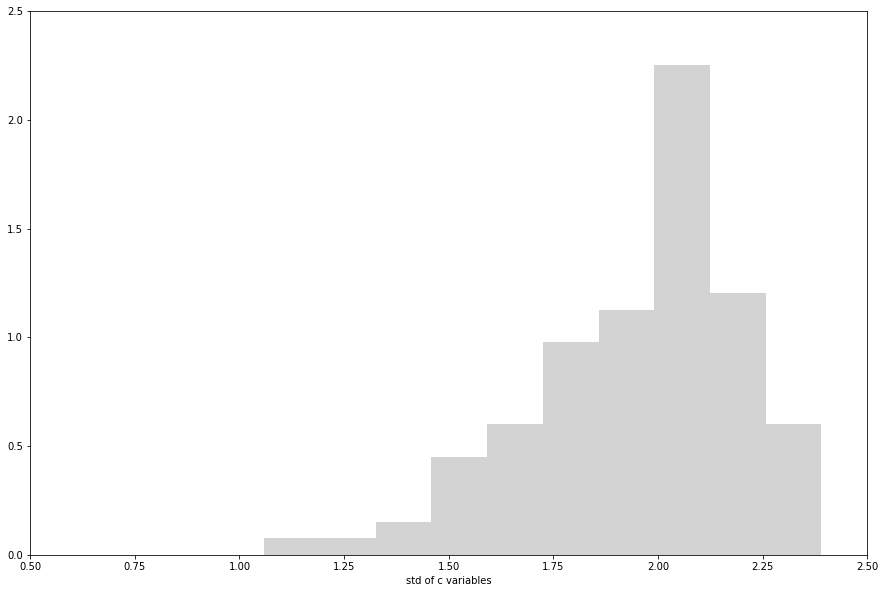

In [37]:
#Computing the standard deviation for 'c_' variables.
mask_c = train_features_without_control.columns.str.contains('^c-[0-99]')

describe_c_variables = train_features_without_control.loc[:,mask_c].describe()
std_c = describe_c_variables.iloc[2]
print('Describe the standard deviation of c variables:')
display(std_c.describe())
print()

#Histogram
print('Histogram:')
fig = plt.figure(figsize=(15,10))

ax = std_c.hist(density = True,
                histtype = 'bar', bins = 10, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('std of c variables')
plt.xlim(left = 0.5, right = 2.5)
plt.ylim(top = 2.5)

(0.5, 2.5)

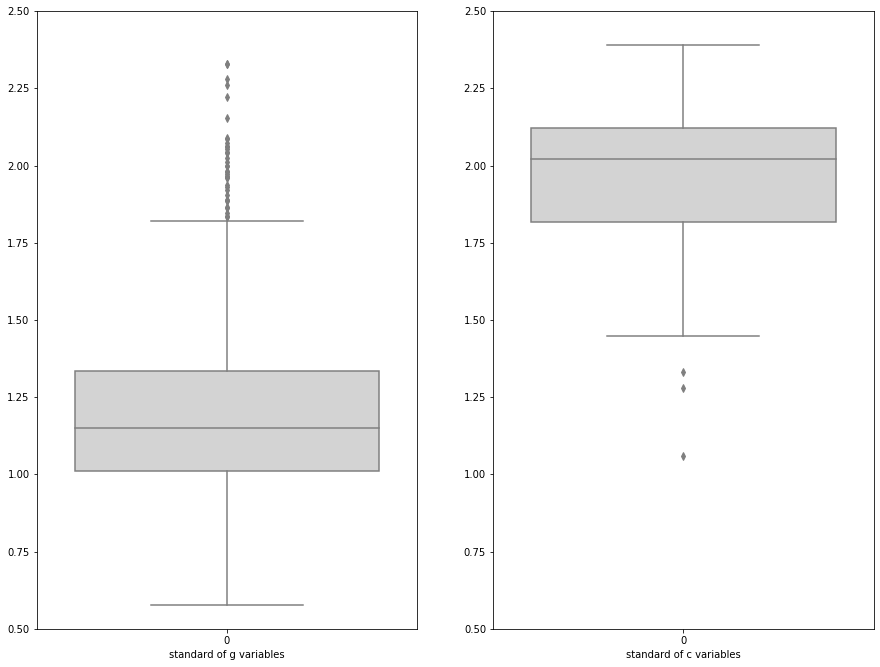

In [27]:
#Summarizing the comparison between g and c variables with a box plot.
fig = plt.figure(figsize=(15,25))

ax1 = fig.add_subplot(2,2,1)
ax1 = sns.boxplot(data = std_g, color = 'LightGray')
plt.xlabel('standard of g variables')
plt.ylim(bottom = 0.5, top = 2.5)


ax2 = fig.add_subplot(2, 2, 2)
ax2 = sns.boxplot(data = std_c, color = 'LightGray')
plt.xlabel('standard of c variables')
plt.ylim(bottom = 0.5, top = 2.5)


From the box plot above, it is clear that the cell viability variables have a higher variability than the gene expression variables.
Lets compare the distribution of these genes and cell variables with the database with only control observations.

Describe the standard deviation of g variables without control:


count    772.000000
mean       1.208584
std        0.290972
min        0.576172
25%        1.009521
50%        1.151367
75%        1.336182
max        2.330078
Name: std, dtype: float64


Describe the standard deviation of g variables with only control:


count    772.000000
mean       0.922428
std        0.130179
min        0.438965
25%        0.841309
50%        0.911865
75%        0.997559
max        1.492188
Name: std, dtype: float64


Histogram:


(0.0, 2.5)

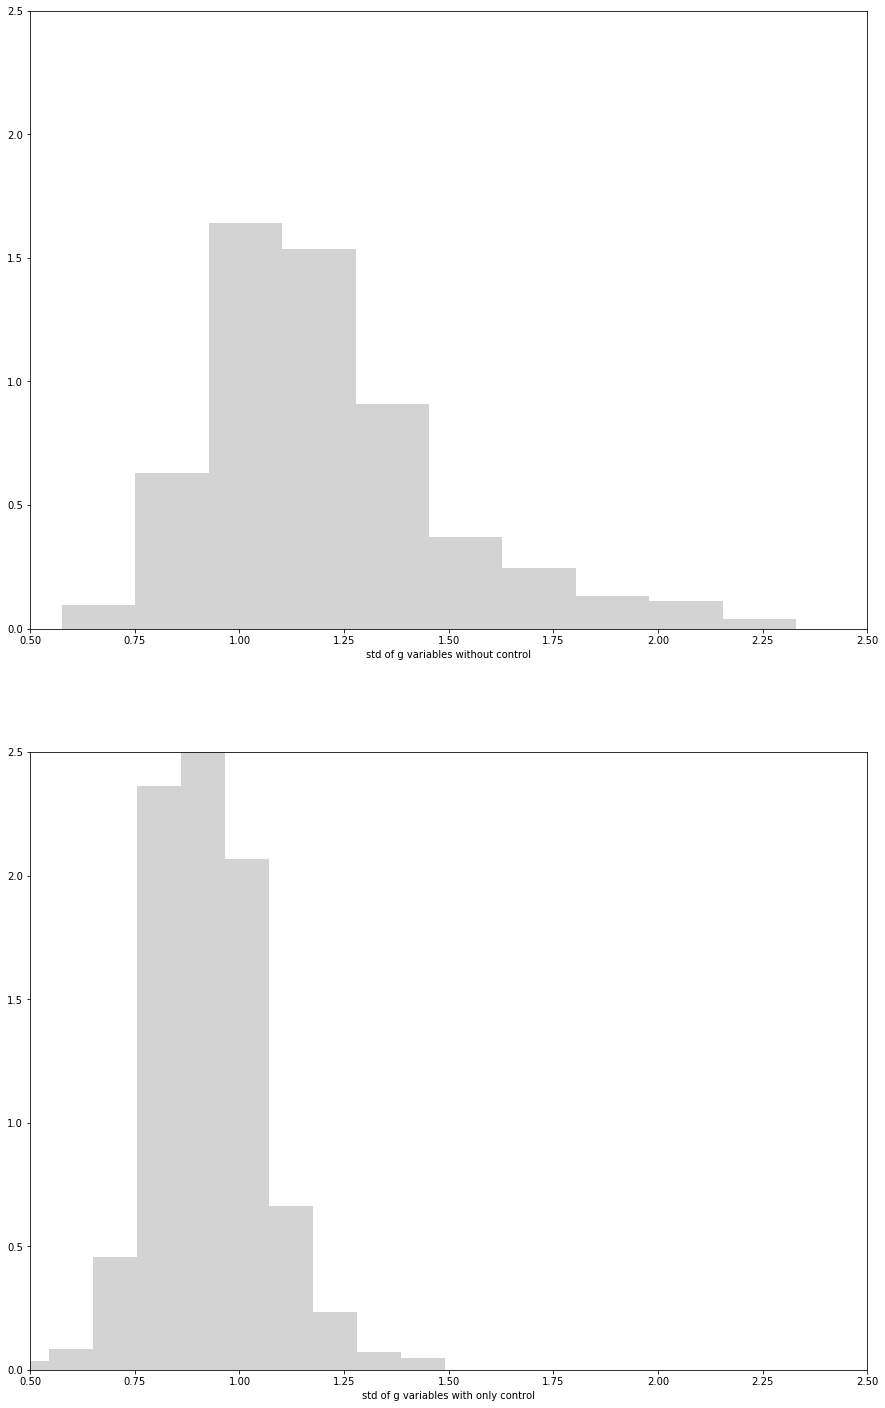

In [39]:
describe_g_variables_without_control = train_features_without_control.loc[:,mask_g].describe()
std_g_without_control = describe_g_variables_without_control.iloc[2]
print('Describe the standard deviation of g variables without control:')
display(std_g_without_control.describe())
print()
describe_g_variables_only_control = train_features_only_control.loc[:,mask_g].describe()
std_g_only_control = describe_g_variables_only_control.iloc[2]
print('Describe the standard deviation of g variables with only control:')
display(std_g_only_control.describe())
print()

print('Histogram:')
fig = plt.figure(figsize=(15,25))

ax1 = fig.add_subplot(2,1,1)
ax1 = std_g_without_control.hist(density = True,
                histtype = 'bar', bins = 10, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('std of g variables without control')
plt.xlim(left = 0.5, right = 2.5)
plt.ylim(top = 2.5)

ax2 = fig.add_subplot(2,1,2)
ax2 = std_g_only_control.hist(density = True,
                histtype = 'bar', bins = 10, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('std of g variables with only control')
plt.xlim(left = 0.5, right = 2.5)
plt.ylim(top = 2.5)

Describe the standard deviation of c variables without control:


count    100.000000
mean       1.959482
std        0.255153
min        1.059570
25%        1.817627
50%        2.020508
75%        2.121094
max        2.390625
Name: std, dtype: float64


Describe the standard deviation of c variables with only control:


count    100.000000
mean       0.731738
std        0.063132
min        0.614746
25%        0.690186
50%        0.716797
75%        0.755005
max        0.972656
Name: std, dtype: float64


Histogram:


(0.0, 2.5)

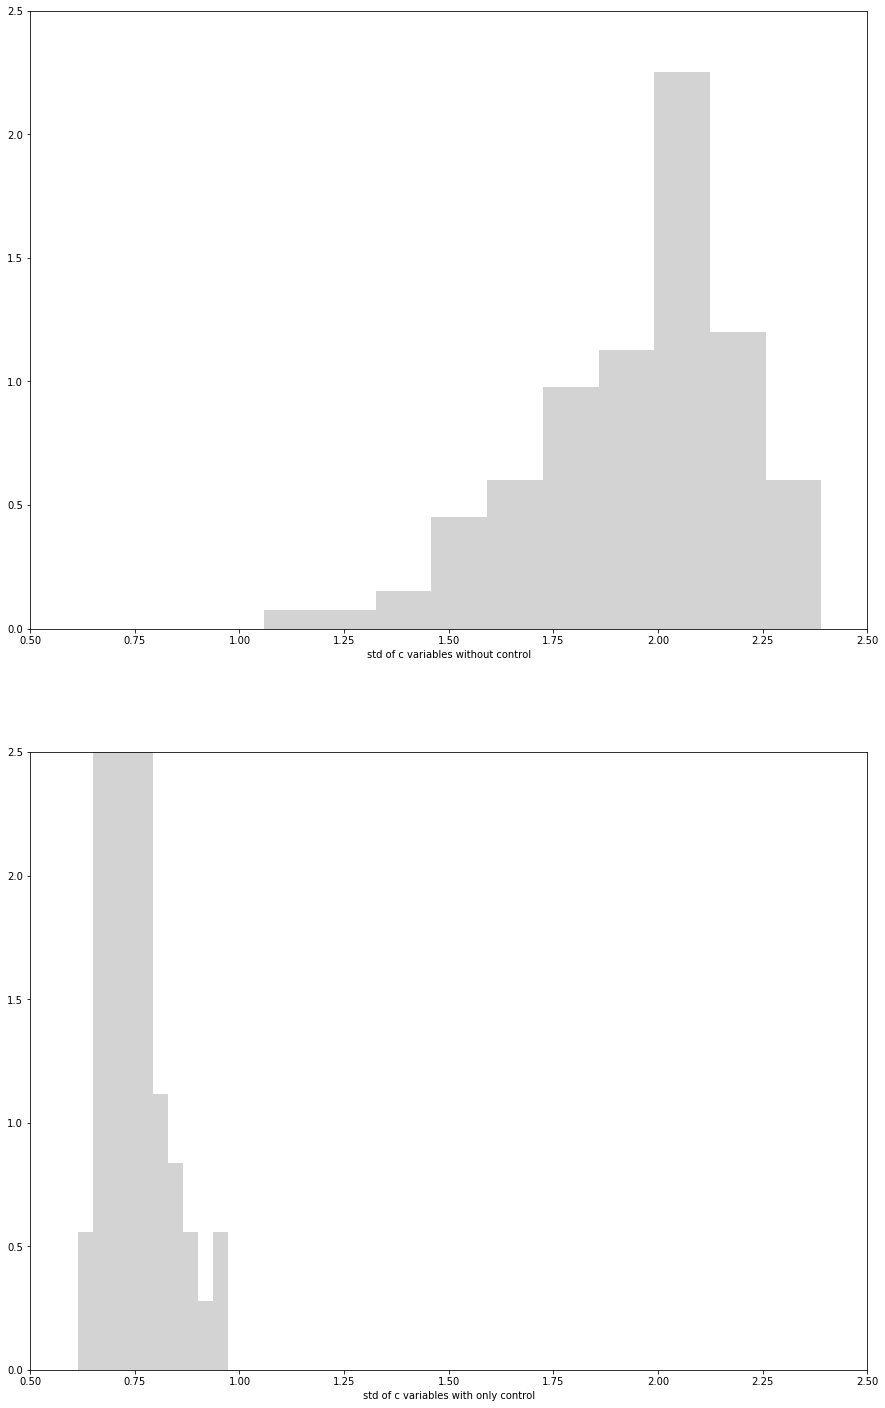

In [38]:
describe_c_variables_without_control = train_features_without_control.loc[:,mask_c].describe()
std_c_without_control = describe_c_variables_without_control.iloc[2]
print('Describe the standard deviation of c variables without control:')
display(std_c_without_control.describe())
print()
describe_c_variables_only_control = train_features_only_control.loc[:,mask_c].describe()
std_c_only_control = describe_c_variables_only_control.iloc[2]
print('Describe the standard deviation of c variables with only control:')
display(std_c_only_control.describe())
print()

print('Histogram:')
fig = plt.figure(figsize=(15,25))

ax1 = fig.add_subplot(2,1,1)
ax1 = std_c_without_control.hist(density = True,
                histtype = 'bar', bins = 10, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('std of c variables without control')
plt.xlim(left = 0.5, right = 2.5)
plt.ylim(top = 2.5)

ax2 = fig.add_subplot(2,1,2)
ax2 = std_c_only_control.hist(density = True,
                histtype = 'bar', bins = 10, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('std of c variables with only control')
plt.xlim(left = 0.5, right = 2.5)
plt.ylim(top = 2.5)

We can see that the distribution of genes and cell variables are different for the control and treatment group, especially for the cell variables.\
Lets repeat the same study considering the difference in the dosage variable,

Describe the standard deviation of g variables, dosage = "D1":


count    772.000000
mean       1.230800
std        0.327410
min        0.416992
25%        1.010498
50%        1.156250
75%        1.388916
max        2.431641
Name: std, dtype: float64


Describe the standard deviation of g variables, dosage = "D2":


count    772.000000
mean       1.170689
std        0.291642
min        0.541504
25%        0.980347
50%        1.113770
75%        1.304688
max        2.339844
Name: std, dtype: float64


Histogram:


(0.0, 2.5)

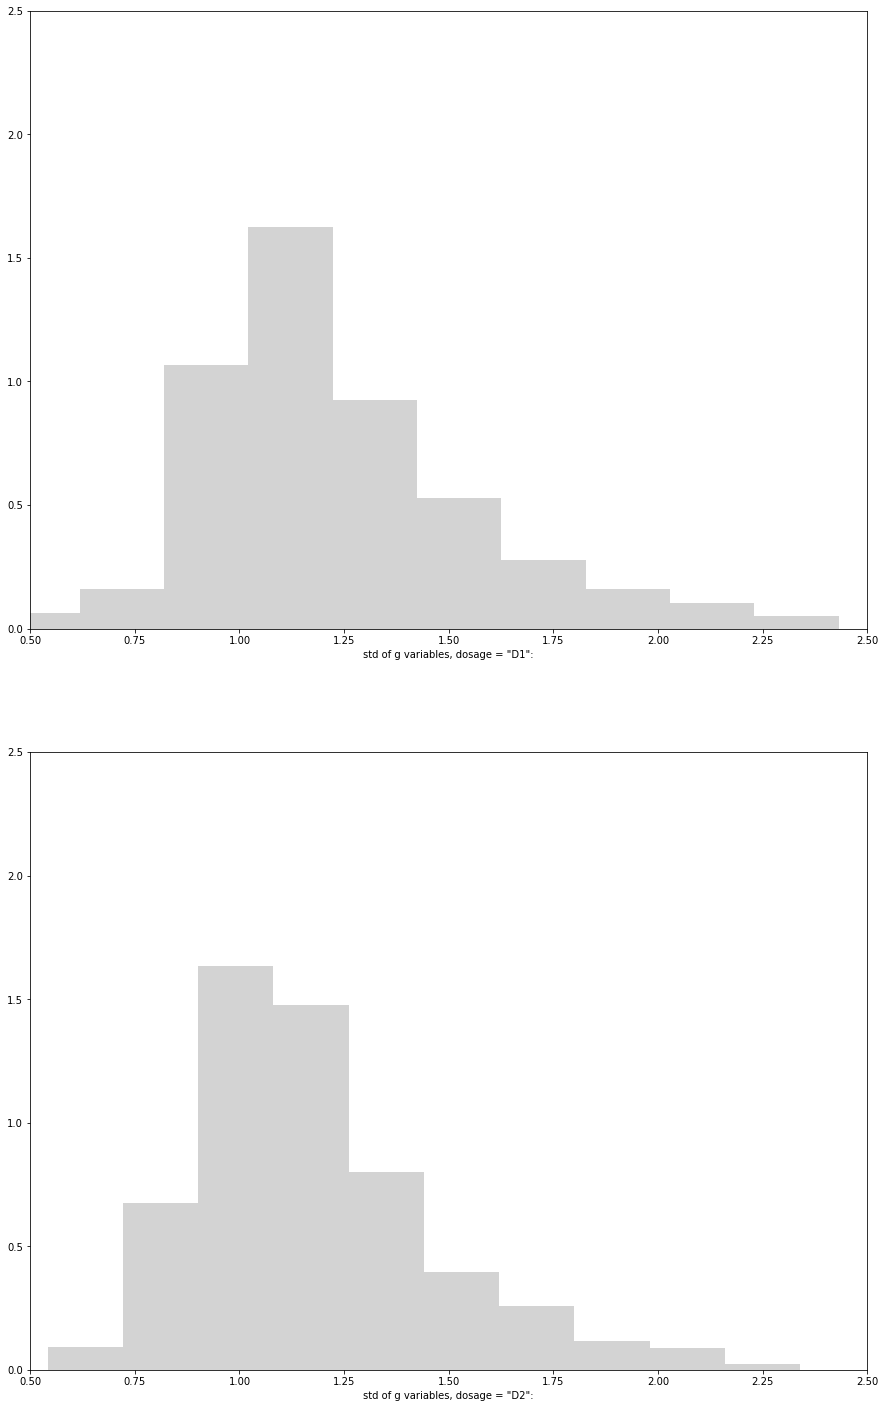

In [44]:
train_g_variables = train_features_without_control.loc[:,mask_g]
describe_g_variables_D1 = train_g_variables[np.in1d(train_features_without_control['cp_dose'], 'D1')].describe()
std_g_D1 = describe_g_variables_D1.iloc[2]
print('Describe the standard deviation of g variables, dosage = "D1":')
display(std_g_D1.describe())
print()
std_g_D2 = train_g_variables[np.in1d(train_features_without_control['cp_dose'], 'D2')].describe()
std_g_D2 = std_g_D2.iloc[2]
print('Describe the standard deviation of g variables, dosage = "D2":')
display(std_g_D2.describe())
print()

print('Histogram:')
fig = plt.figure(figsize=(15,25))

ax1 = fig.add_subplot(2,1,1)
ax1 = std_g_D1.hist(density = True,
                histtype = 'bar', bins = 10, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('std of g variables, dosage = "D1":')
plt.xlim(left = 0.5, right = 2.5)
plt.ylim(top = 2.5)

ax2 = fig.add_subplot(2,1,2)
ax2 = std_g_D2.hist(density = True,
                histtype = 'bar', bins = 10, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('std of g variables, dosage = "D2":')
plt.xlim(left = 0.5, right = 2.5)
plt.ylim(top = 2.5)

Describe the standard deviation of c variables, dosage = "D1":


count    100.000000
mean       2.084170
std        0.269073
min        1.050781
25%        1.925781
50%        2.132812
75%        2.256836
max        2.533203
Name: std, dtype: float64


Describe the standard deviation of c variables, dosage = "D2":


count    100.000000
mean       1.816162
std        0.247599
min        1.065430
25%        1.675537
50%        1.851562
75%        1.985596
max        2.246094
Name: std, dtype: float64


Histogram:


(0.0, 2.5)

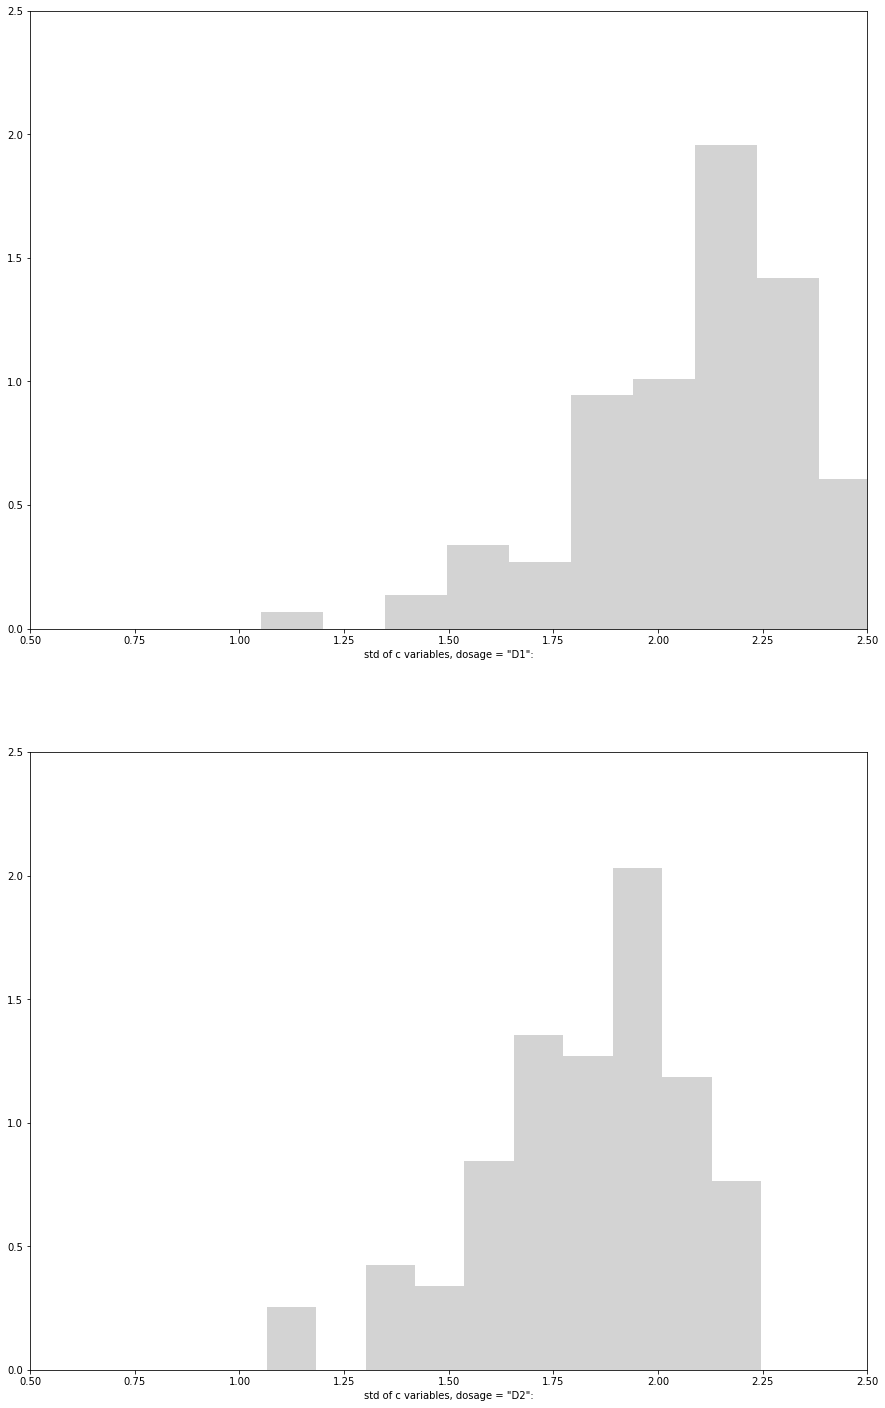

In [45]:
train_c_variables = train_features_without_control.loc[:,mask_c]
describe_c_variables_D1 = train_c_variables[np.in1d(train_features_without_control['cp_dose'], 'D1')].describe()
std_c_D1 = describe_c_variables_D1.iloc[2]
print('Describe the standard deviation of c variables, dosage = "D1":')
display(std_c_D1.describe())
print()
std_c_D2 = train_c_variables[np.in1d(train_features_without_control['cp_dose'], 'D2')].describe()
std_c_D2 = std_c_D2.iloc[2]
print('Describe the standard deviation of c variables, dosage = "D2":')
display(std_c_D2.describe())
print()

print('Histogram:')
fig = plt.figure(figsize=(15,25))

ax1 = fig.add_subplot(2,1,1)
ax1 = std_c_D1.hist(density = True,
                histtype = 'bar', bins = 10, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('std of c variables, dosage = "D1":')
plt.xlim(left = 0.5, right = 2.5)
plt.ylim(top = 2.5)

ax2 = fig.add_subplot(2,1,2)
ax2 = std_c_D2.hist(density = True,
                histtype = 'bar', bins = 10, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('std of c variables, dosage = "D2":')
plt.xlim(left = 0.5, right = 2.5)
plt.ylim(top = 2.5)

There is a small change in the distribution of the genes and cell variables when considering the difference in the dosage. This may imply that the dosage variable is not so importante for our model.\
Lets repeat the study considering the duration of the treatment.

Describe the standard deviation of g variables, duration = 24:


count    772.000000
mean       1.139651
std        0.298476
min        0.493408
25%        0.938721
50%        1.070801
75%        1.260010
max        2.511719
Name: std, dtype: float64


Describe the standard deviation of g variables, duration = 48:


count    772.000000
mean       1.211127
std        0.304735
min        0.571289
25%        1.000000
50%        1.144531
75%        1.344482
max        2.375000
Name: std, dtype: float64


Describe the standard deviation of g variables, duration = 72:


count    772.000000
mean       1.211127
std        0.304735
min        0.571289
25%        1.000000
50%        1.144531
75%        1.344482
max        2.375000
Name: std, dtype: float64


Histogram:


(0.0, 2.5)

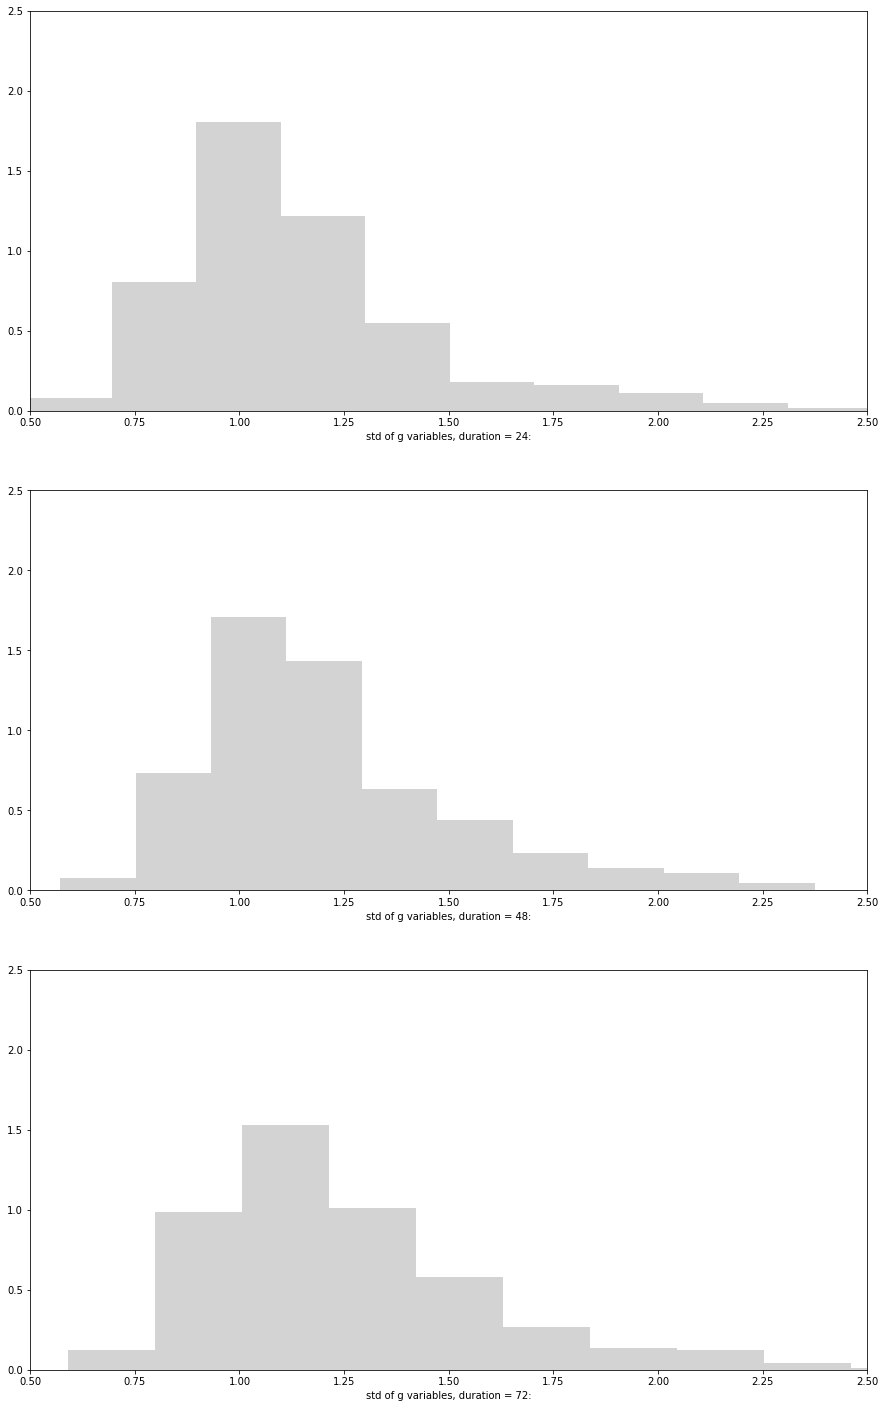

In [50]:
train_g_variables = train_features_without_control.loc[:,mask_g]
std_g_24 = train_g_variables[np.in1d(train_features_without_control['cp_time'], 24)].describe()
std_g_24 = std_g_24.iloc[2]
print('Describe the standard deviation of g variables, duration = 24:')
display(std_g_24.describe())
print()
std_g_48 = train_g_variables[np.in1d(train_features_without_control['cp_time'], 48)].describe()
std_g_48 = std_g_48.iloc[2]
print('Describe the standard deviation of g variables, duration = 48:')
display(std_g_48.describe())
print()
std_g_72 = train_g_variables[np.in1d(train_features_without_control['cp_time'], 72)].describe()
std_g_72 = std_g_72.iloc[2]
print('Describe the standard deviation of g variables, duration = 72:')
display(std_g_48.describe())
print()

print('Histogram:')
fig = plt.figure(figsize=(15,25))

ax1 = fig.add_subplot(3,1,1)
ax1 = std_g_24.hist(density = True,
                histtype = 'bar', bins = 10, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('std of g variables, duration = 24:')
plt.xlim(left = 0.5, right = 2.5)
plt.ylim(top = 2.5)

ax2 = fig.add_subplot(3,1,2)
ax2 = std_g_48.hist(density = True,
                histtype = 'bar', bins = 10, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('std of g variables, duration = 48:')
plt.xlim(left = 0.5, right = 2.5)
plt.ylim(top = 2.5)

ax3 = fig.add_subplot(3,1,3)
ax3 = std_g_72.hist(density = True,
                histtype = 'bar', bins = 10, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('std of g variables, duration = 72:')
plt.xlim(left = 0.5, right = 2.5)
plt.ylim(top = 2.5)

Describe the standard deviation of c variables, duration = 24:


count    100.000000
mean       1.497441
std        0.307123
min        0.824219
25%        1.261230
50%        1.491211
75%        1.713867
max        2.126953
Name: std, dtype: float64


Describe the standard deviation of c variables, duration = 48:


count    100.000000
mean       1.983350
std        0.265493
min        1.001953
25%        1.810059
50%        2.063477
75%        2.158691
max        2.445312
Name: std, dtype: float64


Describe the standard deviation of c variables, duration = 72:


count    100.000000
mean       1.983350
std        0.265493
min        1.001953
25%        1.810059
50%        2.063477
75%        2.158691
max        2.445312
Name: std, dtype: float64


Histogram:


(0.0, 2.5)

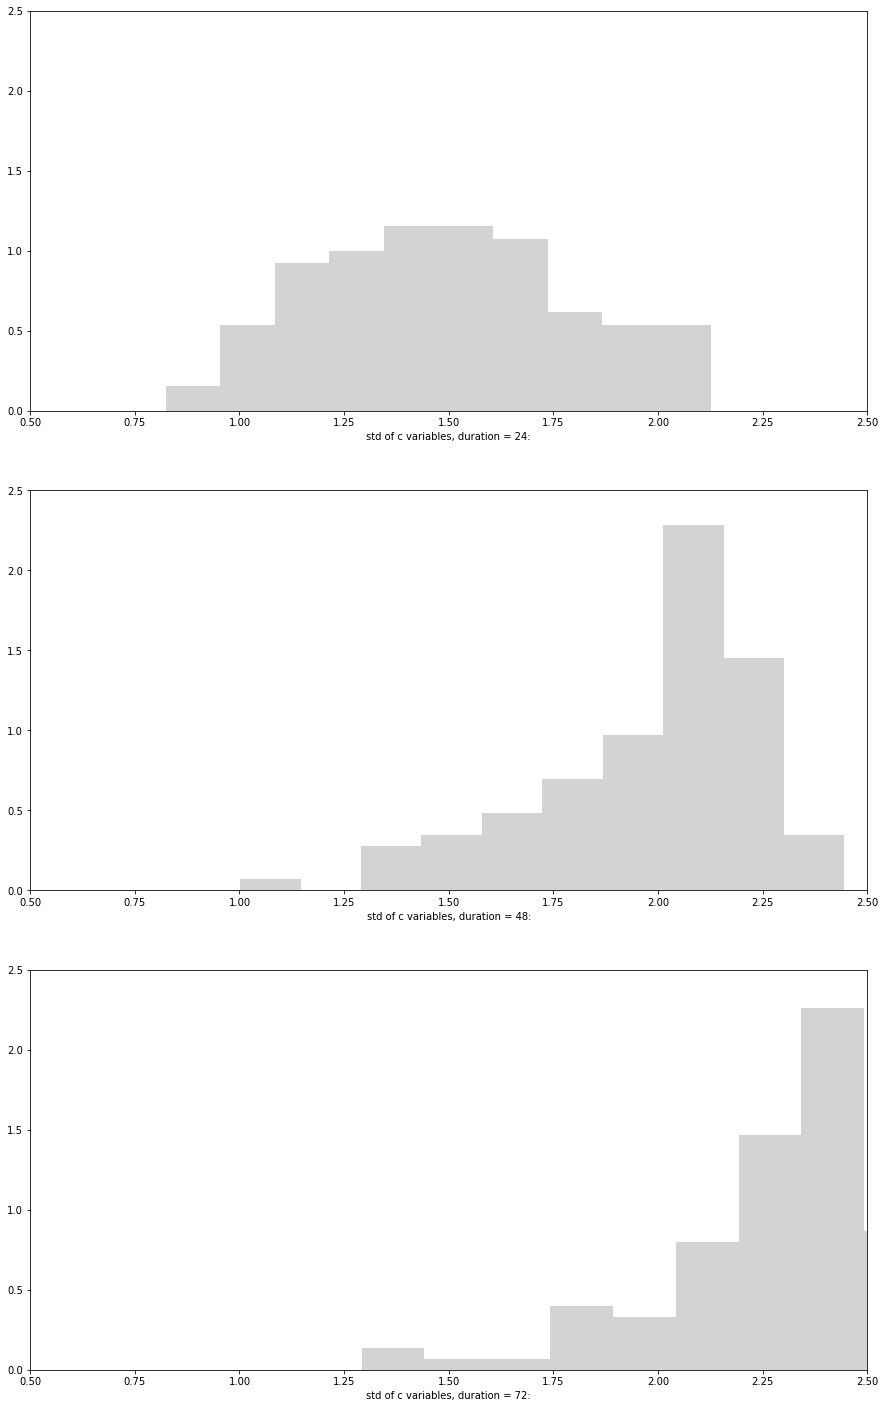

In [51]:
train_c_variables = train_features_without_control.loc[:,mask_c]
std_c_24 = train_c_variables[np.in1d(train_features_without_control['cp_time'], 24)].describe()
std_c_24 = std_c_24.iloc[2]
print('Describe the standard deviation of c variables, duration = 24:')
display(std_c_24.describe())
print()
std_c_48 = train_c_variables[np.in1d(train_features_without_control['cp_time'], 48)].describe()
std_c_48 = std_c_48.iloc[2]
print('Describe the standard deviation of c variables, duration = 48:')
display(std_c_48.describe())
print()
std_c_72 = train_c_variables[np.in1d(train_features_without_control['cp_time'], 72)].describe()
std_c_72 = std_c_72.iloc[2]
print('Describe the standard deviation of c variables, duration = 72:')
display(std_c_48.describe())
print()

print('Histogram:')
fig = plt.figure(figsize=(15,25))

ax1 = fig.add_subplot(3,1,1)
ax1 = std_c_24.hist(density = True,
                histtype = 'bar', bins = 10, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('std of c variables, duration = 24:')
plt.xlim(left = 0.5, right = 2.5)
plt.ylim(top = 2.5)

ax2 = fig.add_subplot(3,1,2)
ax2 = std_c_48.hist(density = True,
                histtype = 'bar', bins = 10, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('std of c variables, duration = 48:')
plt.xlim(left = 0.5, right = 2.5)
plt.ylim(top = 2.5)

ax3 = fig.add_subplot(3,1,3)
ax3 = std_c_72.hist(density = True,
                histtype = 'bar', bins = 10, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('std of c variables, duration = 72:')
plt.xlim(left = 0.5, right = 2.5)
plt.ylim(top = 2.5)

For the genes variable we cannot see a significant difference in the distribution when considering the duration of the treatment. However, for the cell variables, there are a visible difference.

Now, lets see the correlations.

In [31]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def correlation_variables(db, variable_type, n, correlation_cut):
    
    if variable_type == 'c':
        mask_type = db.columns.str.contains('^c-[0-99]')
    elif variable_type == 'g':
        mask_type = db.columns.str.contains('^g-*')
        
    db_variables = db.loc[:,mask_type]

    #Correlation
    corr_matrix = db_variables.corr()
    corr_table = corr_matrix.abs().unstack()
    labels_to_drop = get_redundant_pairs(db_variables)
    corr_table = corr_table.drop(labels = labels_to_drop).sort_values(ascending = False)

    print('Variable type: ' + variable_type)
    print()
    print("Top Absolute Correlations")
    print(corr_table[: n])
    print()
    print("Least Absolute Correlations")
    print(corr_table[len(corr_table) - n: ])
    print()
    print("Variables with correlation higher than", correlation_cut, ':', len(corr_table[abs(corr_table) > correlation_cut]))
    print("Percent:", round(len(corr_table[abs(corr_table) > correlation_cut]) / len(corr_table), 4))
    print()

    size_x = 20     #This is a good size to visualise the heatmap saved as .png
    size_y = 20
    plt.figure(figsize = (size_x, size_y))
    sns.set(font_scale = 1.5)

    ax = sns.heatmap(corr_matrix, annot = False, linewidth = 0.2, cmap='coolwarm')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    plt.tight_layout()
    plt.savefig(path_analysis + 'variable_type_' + variable_type + '.png')

    plt.show() 

Variable type: g

Top Absolute Correlations
g-37   g-50     0.913074
g-50   g-672    0.854034
g-37   g-489    0.850602
g-50   g-489    0.848720
g-349  g-460    0.847758
g-369  g-569    0.844013
g-63   g-195    0.840621
g-123  g-744    0.840604
g-121  g-672    0.836731
g-248  g-460    0.834571
dtype: float64

Least Absolute Correlations
g-691  g-707    7.292351e-06
g-73   g-215    6.288721e-06
g-180  g-182    4.562231e-06
g-71   g-617    3.295390e-06
g-74   g-188    2.902724e-06
g-616  g-619    2.289878e-06
g-362  g-572    1.984592e-06
g-111  g-399    6.147029e-07
g-425  g-542    4.466530e-07
g-679  g-756    1.793006e-07
dtype: float64

Variables with correlation higher than 0.5 : 15691
Percent: 0.0527



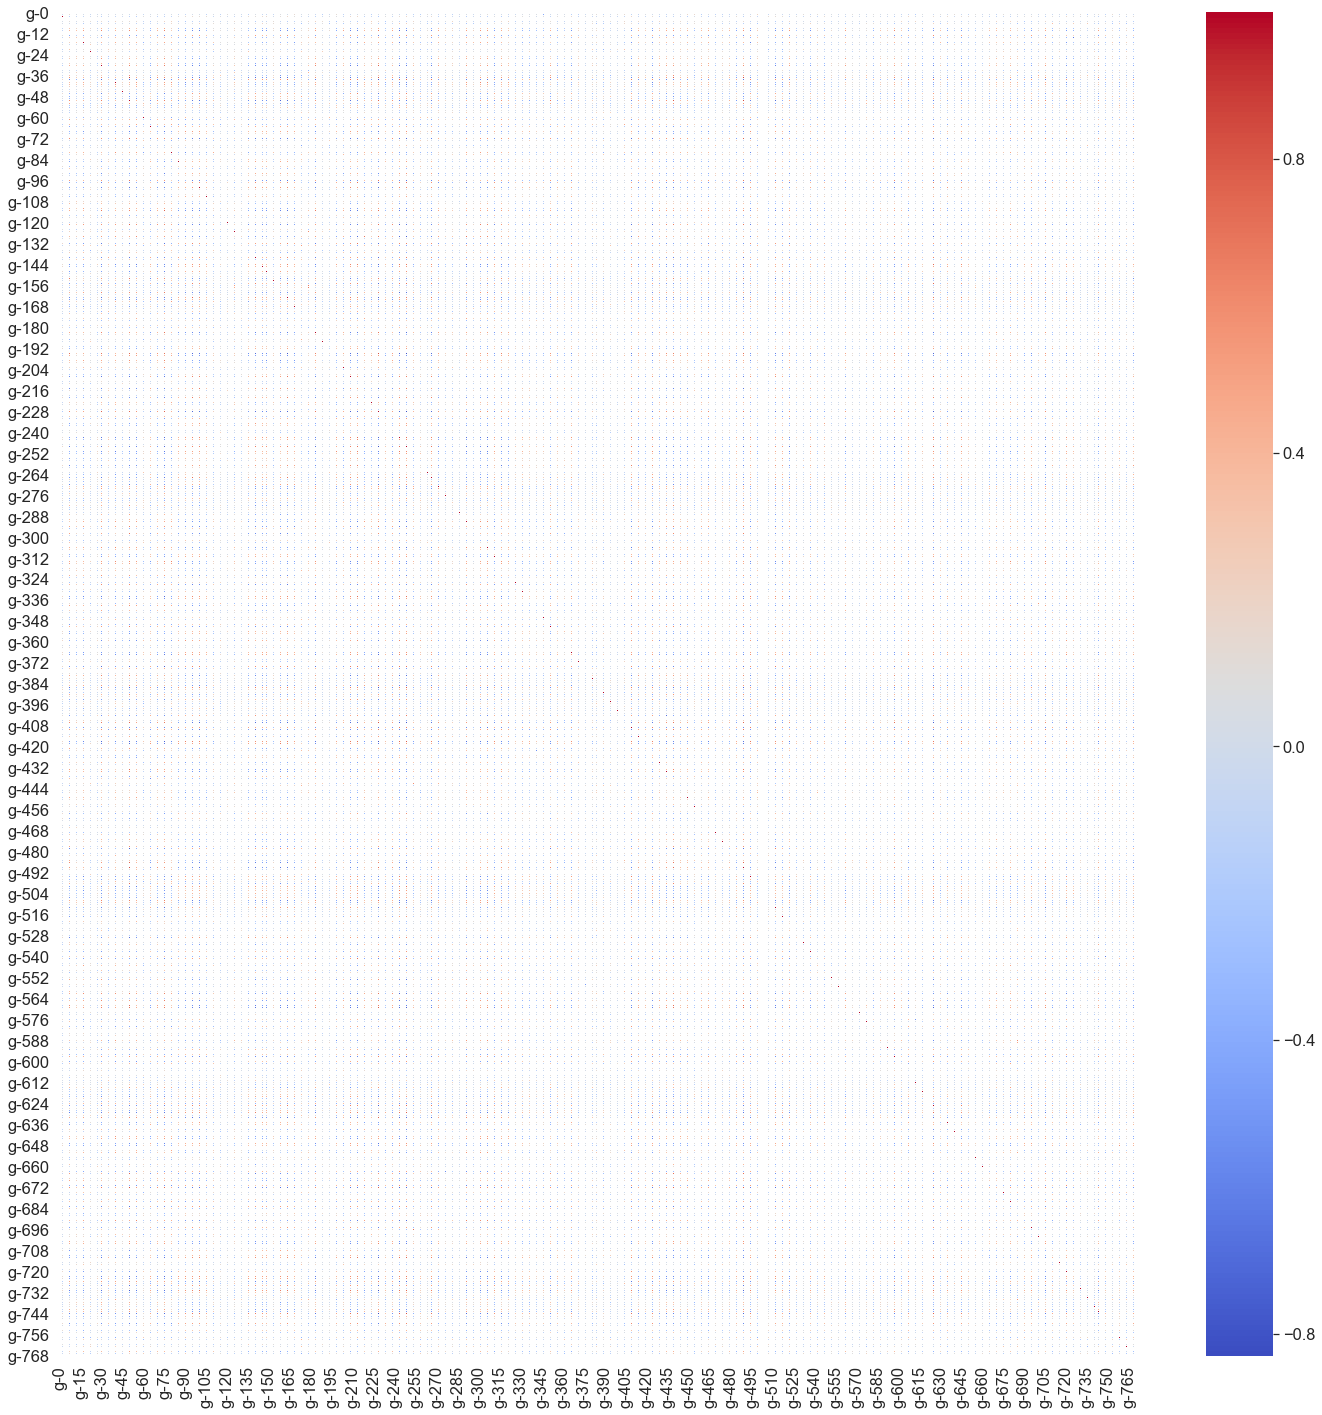

In [29]:
correlation_variables(train_features_without_control, 'g', 10, 0.5)

For the 'g' variables, we can see that they are not highly correlated. Less than 5% has a correlation higher than 0.5 or less than -0.5.
This imply that we won't be able to reduce very much the number of variables using PCA.

Variable type: c

Top Absolute Correlations
c-42  c-52    0.929310
c-13  c-73    0.925992
      c-26    0.925509
c-11  c-55    0.920315
c-6   c-33    0.920252
c-4   c-52    0.919693
      c-42    0.919554
c-38  c-94    0.918899
c-13  c-94    0.918753
c-38  c-63    0.918356
dtype: float64

Least Absolute Correlations
c-22  c-78    0.692841
      c-32    0.688880
c-74  c-99    0.688754
c-22  c-29    0.684470
      c-58    0.683219
c-37  c-74    0.677523
c-22  c-74    0.673428
c-58  c-74    0.670249
c-22  c-37    0.660485
c-16  c-22    0.620339
dtype: float64

Variables with correlation higher than 0.8 : 4231
Percent: 0.8547



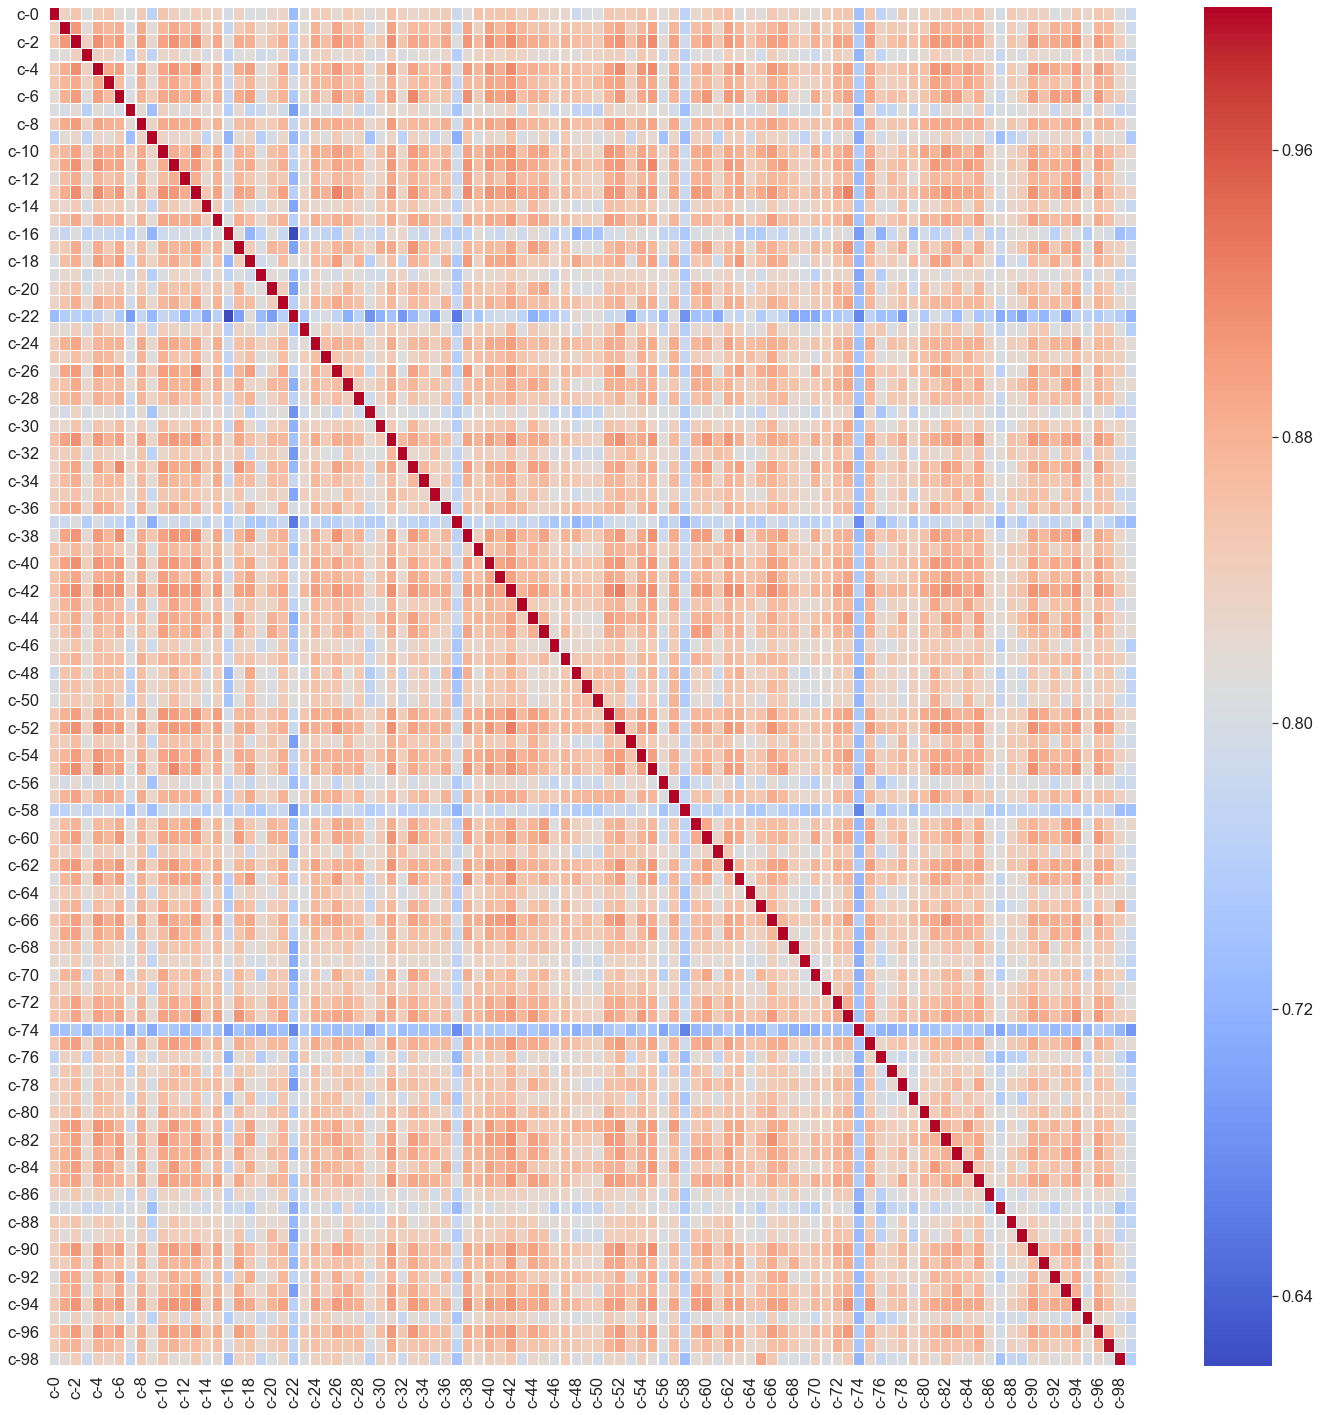

In [30]:
correlation_variables(train_features_without_control, 'c', 10, 0.8)

On the other hand, for the 'c' variables, we can see that most variables (more than 85%) have a correlation higher than 80%.\
Even the least correlated variables have a correlation higher than 60%. Therefore, we can do a PCA to use less variables and increase the performance of our model.

In [59]:
# PCA
def pca_variabels(db, variable_type, interval_explained_variance_low, interval_explained_variance_high):
    '''
    pca_variabels(train_features_without_control, 'g', 340, 350)
    '''
    if variable_type == 'c':
        mask_type = db.columns.str.contains('^c-[0-99]')
    elif variable_type == 'g':
        mask_type = db.columns.str.contains('^g-*')

    db_variables = db.loc[:,mask_type]
    pca = PCA(n_components = len(db_variables.columns),random_state = 4)
    pca.fit(db_variables)

    explained_variance = []

    sum_variance = 0
    num_variables = 0
    for variance in pca.explained_variance_ratio_:
        sum_variance += variance
        num_variables += 1
        explained_variance.append([num_variables, sum_variance])

    print("Explained variance:")
    display(explained_variance[interval_explained_variance_low - 1: interval_explained_variance_high])
    
    return pd.DataFrame(data = explained_variance)

In [94]:
#plot PCA: components Vs. explained 
def graph_PCA(db, rotation_x, pace):
    '''
    loss_train_validation(db = log_loss_hp, rotation_x = 0, save_to = save_file_final)
    '''
    fig, ax = plt.subplots(figsize=(20, 15))
    x = db[0]
    y = db[1]

    ax.xaxis.set_ticks(x)
    ax.plot(x, y, color='gray', zorder = 1, linewidth = 0.5, linestyle = 'solid')
    # add two layers of points to create an illusion of a discontinuous line. "zorder" specifies plotting order
    ax.scatter(x, y, s = 64, color = 'white', zorder = 2)
    ax.scatter(x, y, s = 8, color = 'gray', zorder = 3)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.xaxis.set_ticks(list(range(1, len(x), pace)))
    ax.set_facecolor('xkcd:white')
    
    plt.xticks(rotation = rotation_x)

In [32]:
pca_variabels(train_features_without_control, 'g', 340, 350)

Explained variance:


[[340, 0.8991913525540632],
 [341, 0.8995848581835825],
 [342, 0.899976961019838],
 [343, 0.9003675347551505],
 [344, 0.900757728167605],
 [345, 0.9011462278454102],
 [346, 0.9015338718788805],
 [347, 0.901920857617887],
 [348, 0.9023055937468984],
 [349, 0.9026891440261957],
 [350, 0.9030708518689483]]

In [33]:
pca_variabels(train_features_without_control, 'g', 160, 170)

Explained variance:


[[160, 0.7957611131106803],
 [161, 0.7966069326015692],
 [162, 0.797449914778404],
 [163, 0.7982835405366077],
 [164, 0.7991150332657333],
 [165, 0.7999417665242036],
 [166, 0.8007645915189028],
 [167, 0.8015856548041439],
 [168, 0.8024052038294117],
 [169, 0.8032210000048258],
 [170, 0.8040332222550376]]

In [60]:
explained_variance_g = pca_variabels(train_features_without_control, 'g', 65, 75)

Explained variance:


[[65, 0.691356284085056],
 [66, 0.6928249932728514],
 [67, 0.6942798771382861],
 [68, 0.6957240588026277],
 [69, 0.6971613475526929],
 [70, 0.6985830940499781],
 [71, 0.6999916251955483],
 [72, 0.7013822433668204],
 [73, 0.702765276702144],
 [74, 0.7041458361720316],
 [75, 0.7055156978418753]]

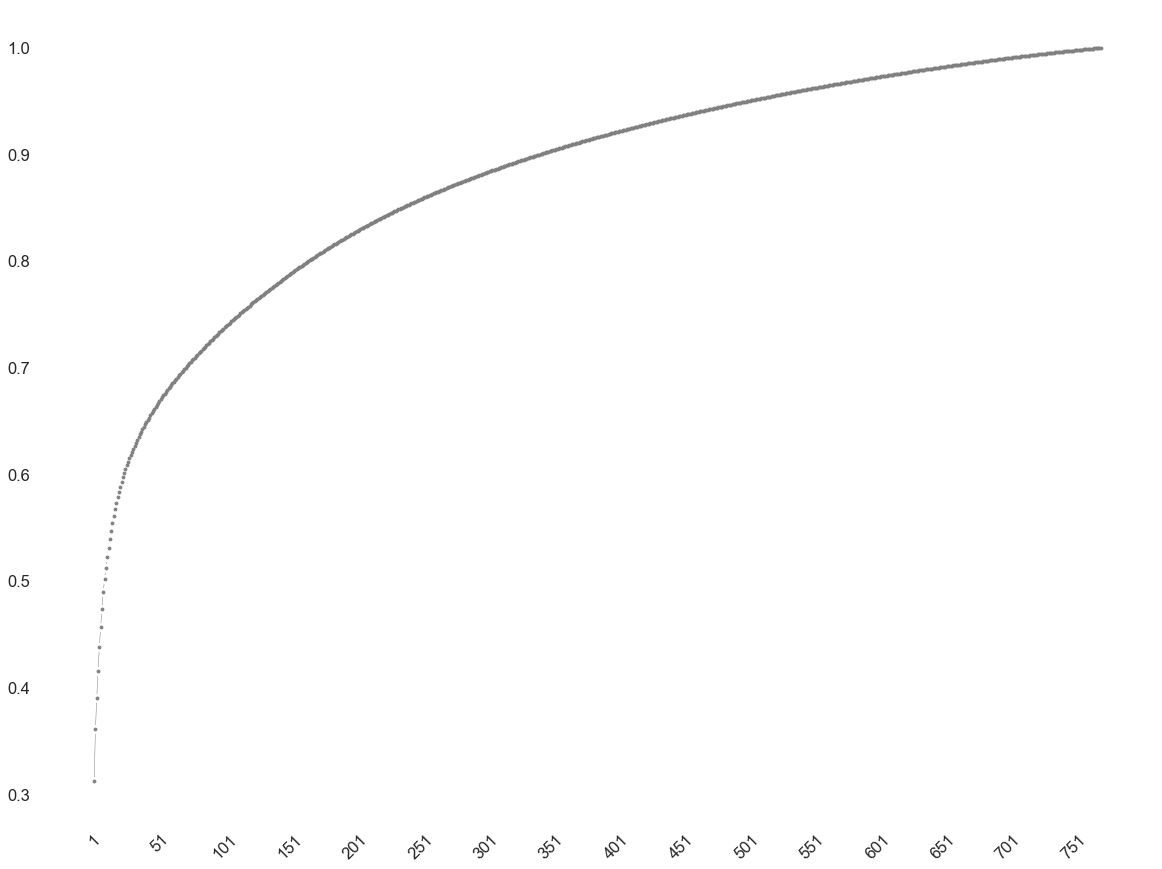

In [95]:
graph_PCA(explained_variance_g, 45, 50)

Despite the correlation heatmap not showing high correlations between variables, insteady of using 772 'g' variables, we can use only 343 components and still explain a little more than 90% of our data variation.\
If we acept a variation of 80% we can use only 166 components.\
If we really want to cut the number of variables, we can use only 72 components and still explain 70% of the variation in the 'g' variables.

In [61]:
explained_variance_c = pca_variabels(train_features_without_control, 'c', 5, 15)

Explained variance:


[[5, 0.883957298719111],
 [6, 0.8877347536473764],
 [7, 0.8911875977737733],
 [8, 0.8943690716306194],
 [9, 0.8974136513946613],
 [10, 0.9002552468096843],
 [11, 0.9027180290538754],
 [12, 0.9049021043131057],
 [13, 0.9070012248915289],
 [14, 0.9090460539656162],
 [15, 0.9109780832090846]]

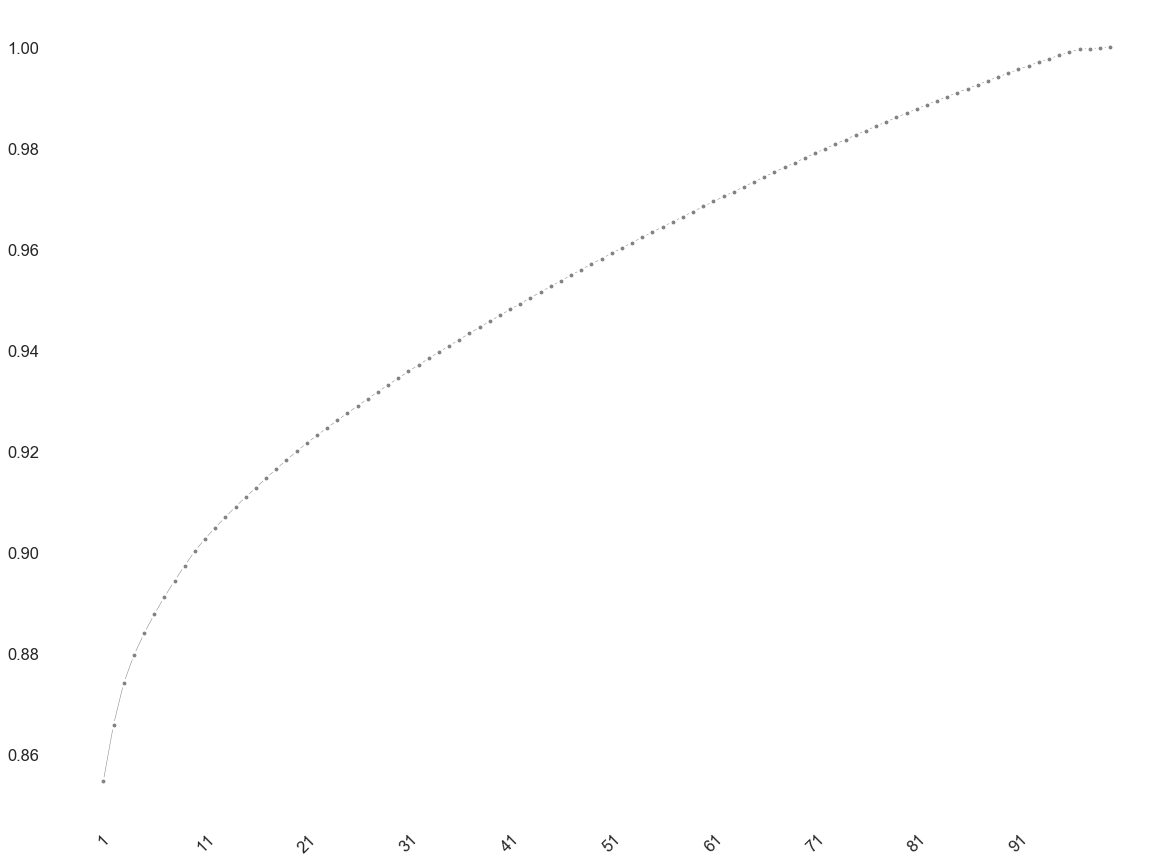

In [96]:
graph_PCA(explained_variance_c, 45, 10)

With the 'c' variables, we can use only 10 components and still explain more than 90% of the variation of the 'c' variables.

In [36]:
#Now that we already studied our exogenous variable, lets see our endogenous ones.
train_labels_without_control

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0      id_9d725b583                            0                       0   
1      id_212b13247                            0                       0   
2      id_4d7888a27                            0                       0   
3      id_6e62ee1d4                            0                       0   
4      id_6073cd653                            0                       0   
...             ...                          ...                     ...   
17571  id_75ed03d3e                            0                       0   
17572  id_ba1d5c28e                            0                       0   
17573  id_37fb1a842                            0                       0   
17574  id_830f74d9f                            0                       0   
17575  id_027496360                            0                       0   

       acat_inhibitor  acetylcholine_receptor_agonist  \
0                   0                               0   
1                   0                               0   
2                   0                               0   
3                   0                               0   
4                   0                               0   
...               ...                             ...   
17571               0                               0   
17572               0                               0   
17573               0                               0   
17574               0                               0   
17575               0                               0   

       acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                      0                               0   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               0   
...                                  ...                             ...   
17571                                  0                               0   
17572                                  0                               0   
17573                                  0                               0   
17574                                  0                               0   
17575                                  0                               0   

       adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   
...                           ...                            ...   
17571                           0                              0   
17572                           0                              0   
17573                           0                              0   
17574                           0                              0   
17575                           0                              0   

       adenylyl_cyclase_activator  ...  trpv_agonist  trpv_antagonist  \
0                               0  ...             0                0   
1                               0  ...             0                0   
2                               0  ...             0                0   
3                               0  ...             0                0   
4                               0  ...             0                0   
...                           ...  ...           ...              ...   
17571                           0  ...             0                0   
17572                           0  ...             0                0   
17573                       

We can see that we have 206 differents classifications of mechanism of action.
We already know that one drug may have more than one MoA, but lets plot again the histogram of the number of mechanisms of action for each drug without clustering by variable.

Describe the endogenous varibles:


count    17576.000000
mean         0.769515
std          0.677847
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          7.000000
Name: sum_MoA, dtype: float64


Histogram:


(0.0, 0.6)

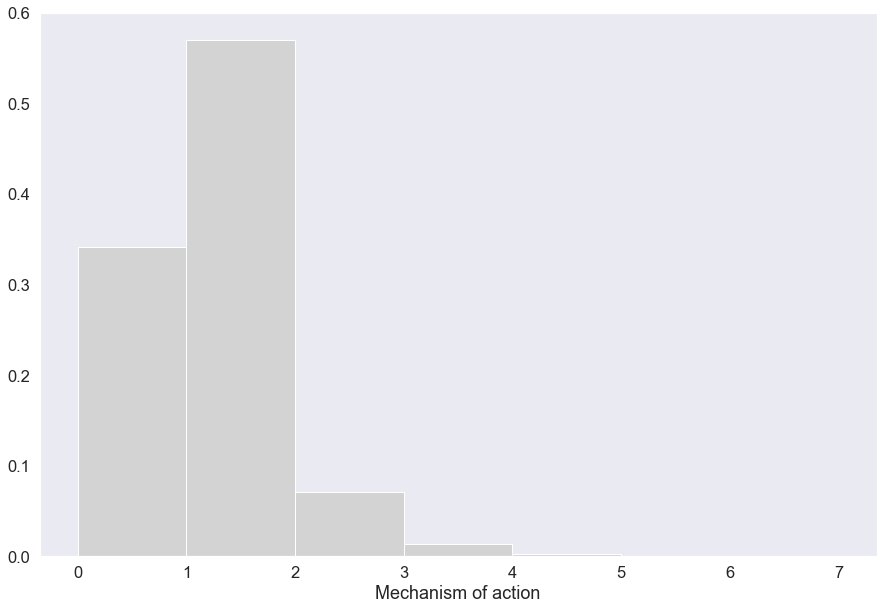

In [37]:
print('Describe the endogenous varibles:')
display(train_labels_without_control['sum_MoA'].describe())
print()

#Histogram
print('Histogram:')
fig = plt.figure(figsize=(15,10))
ax = train_labels_without_control['sum_MoA'].hist(density = True,
                histtype = 'bar', bins = 7, align = 'mid', orientation = 'vertical',
                color = 'LightGray', edgecolor = None)
plt.grid(b = None)
plt.xlabel('Mechanism of action')
plt.ylim(top=0.6)


Box plot:


Text(0.5, 0, 'Mechanism of action')

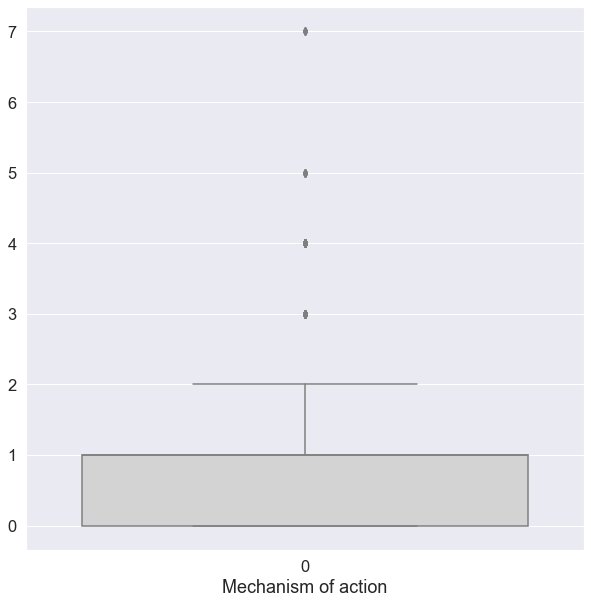

In [38]:
#Box plot
print('Box plot:')
fig = plt.figure(figsize=(10,10))

ax = sns.boxplot(data = train_labels_without_control['sum_MoA'], color = 'LightGray')
plt.xlabel('Mechanism of action')

As we can see, even without the control group, about 35% of the drugs in our database does not have any mechanism of action.
It would be nice if we had access to more information about our database, or if we could talk with someone of the field to try to understand if is normal to have so many drugs without any MoA. 

We have differents types of mechanisms of action, lets try to understand them a little.

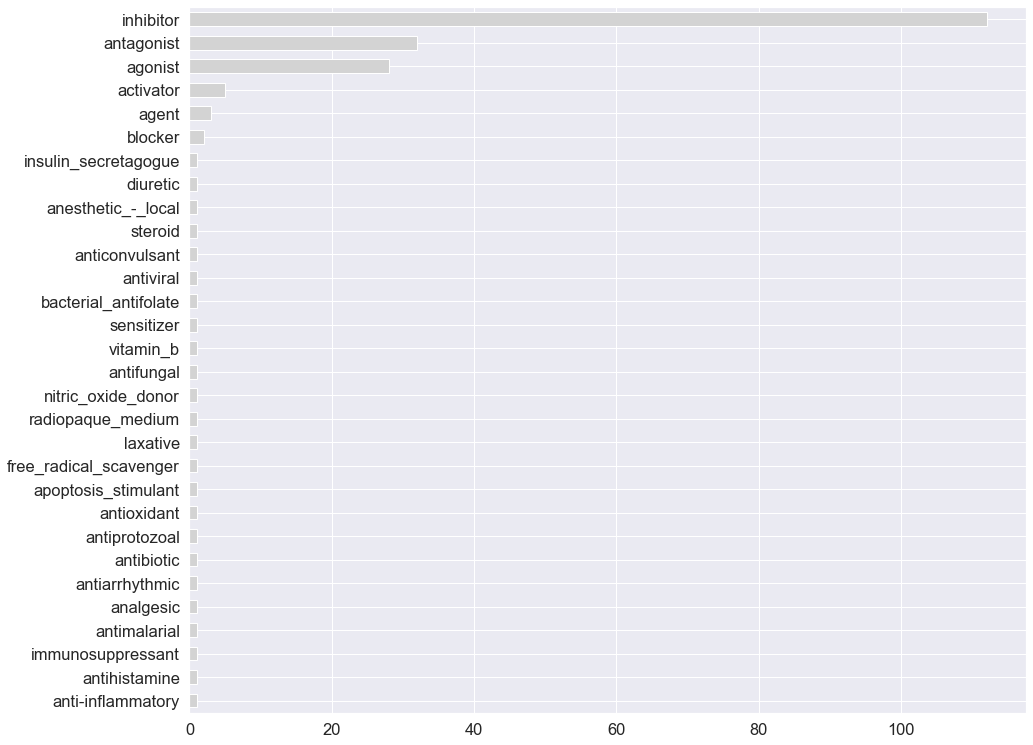

In [40]:
#Types of MoA
mechanism_of_action_type_aux = train_labels_without_control.drop(['sig_id', 'sum_MoA'], axis = 1).columns
mechanism_of_action_type_aux_split = mechanism_of_action_type_aux.str.split('_')

mechanism_of_action_type = []
for i in range(len(mechanism_of_action_type_aux_split)):
    #Words that appear only once
    if mechanism_of_action_type_aux_split[i][-1] in ['b', 'stimulant', 'medium', 'local', 'donor',' sensitizer',
                                                    'laxative','anticonvulsant','secretagogue', 'antibiotic',
                                                    'antiprotozoal','antifolate','antimalarial', 'immunosuppressant',
                                                    'antioxidant','antifungal','scavenger', 'antiviral',
                                                    'steroid','antihistamine','diuretic', 'analgesic',
                                                    'antiarrhythmic','anti-inflammatory']:
        mechanism_of_action_type.append(mechanism_of_action_type_aux[i])
    else:
        mechanism_of_action_type.append(mechanism_of_action_type_aux_split[i][-1])


mechanism_of_action_type_df = pd.DataFrame(data = mechanism_of_action_type)
mechanism_of_action_type_df_barh_graph = mechanism_of_action_type_df[0].value_counts().sort_values()
mechanism_of_action_type_df_barh_graph.plot(kind='barh', figsize=(15,13), width = 0.58, rot = 0,
                                           align = 'center', color = 'LightGray', edgecolor = None)

Most of our mechanisms of action are inhibitors.

Considering that one drug can have more than one MoA, again it would be nice to talk with someone of the field to know, for example, if it is possible to one drug to be a inhibitor and an activator at the same time.

Lets now verify if our data base is unbalanced. Lets count how many drugs of each MoA we have.

In [40]:
sum_MoA = pd.DataFrame(data = train_labels_without_control.drop(['sig_id', 'sum_MoA'], axis = 1).sum().sort_values(ascending = False), columns = ['Count'])
sum_MoA['Percent'] = round(sum_MoA['Count'] / len(train_labels_without_control), 4)
sum_MoA.head(10)

Count  Percent
nfkb_inhibitor                    687   0.0391
proteasome_inhibitor              600   0.0341
dopamine_receptor_antagonist      336   0.0191
cyclooxygenase_inhibitor          334   0.0190
serotonin_receptor_antagonist     323   0.0184
dna_inhibitor                     320   0.0182
adrenergic_receptor_antagonist    299   0.0170
glutamate_receptor_antagonist     284   0.0162
cdk_inhibitor                     274   0.0156
egfr_inhibitor                    270   0.0154

Unfortunately, as we can see, most of our MoA has less than 4% of positive labels.\
This unbalanced data may b a problem in modeling.

Top Absolute Correlations:
nfkb_inhibitor                     proteasome_inhibitor                 0.920824
kit_inhibitor                      pdgfr_inhibitor                      0.920753
flt3_inhibitor                     kit_inhibitor                        0.751442
                                   pdgfr_inhibitor                      0.699580
aldehyde_dehydrogenase_inhibitor   trpv_agonist                         0.534294
nitric_oxide_production_inhibitor  nrf2_activator                       0.466714
apoptosis_stimulant                caspase_activator                    0.401340
insulin_sensitizer                 ppar_receptor_agonist                0.397986
ikk_inhibitor                      nitric_oxide_production_inhibitor    0.368717
caspase_activator                  hiv_inhibitor                        0.343359
dtype: float64

Least Absolute Correlations:
laxative                                    ubiquitin_specific_protease_inhibitor    0.000114
erbb2_inhibitor         

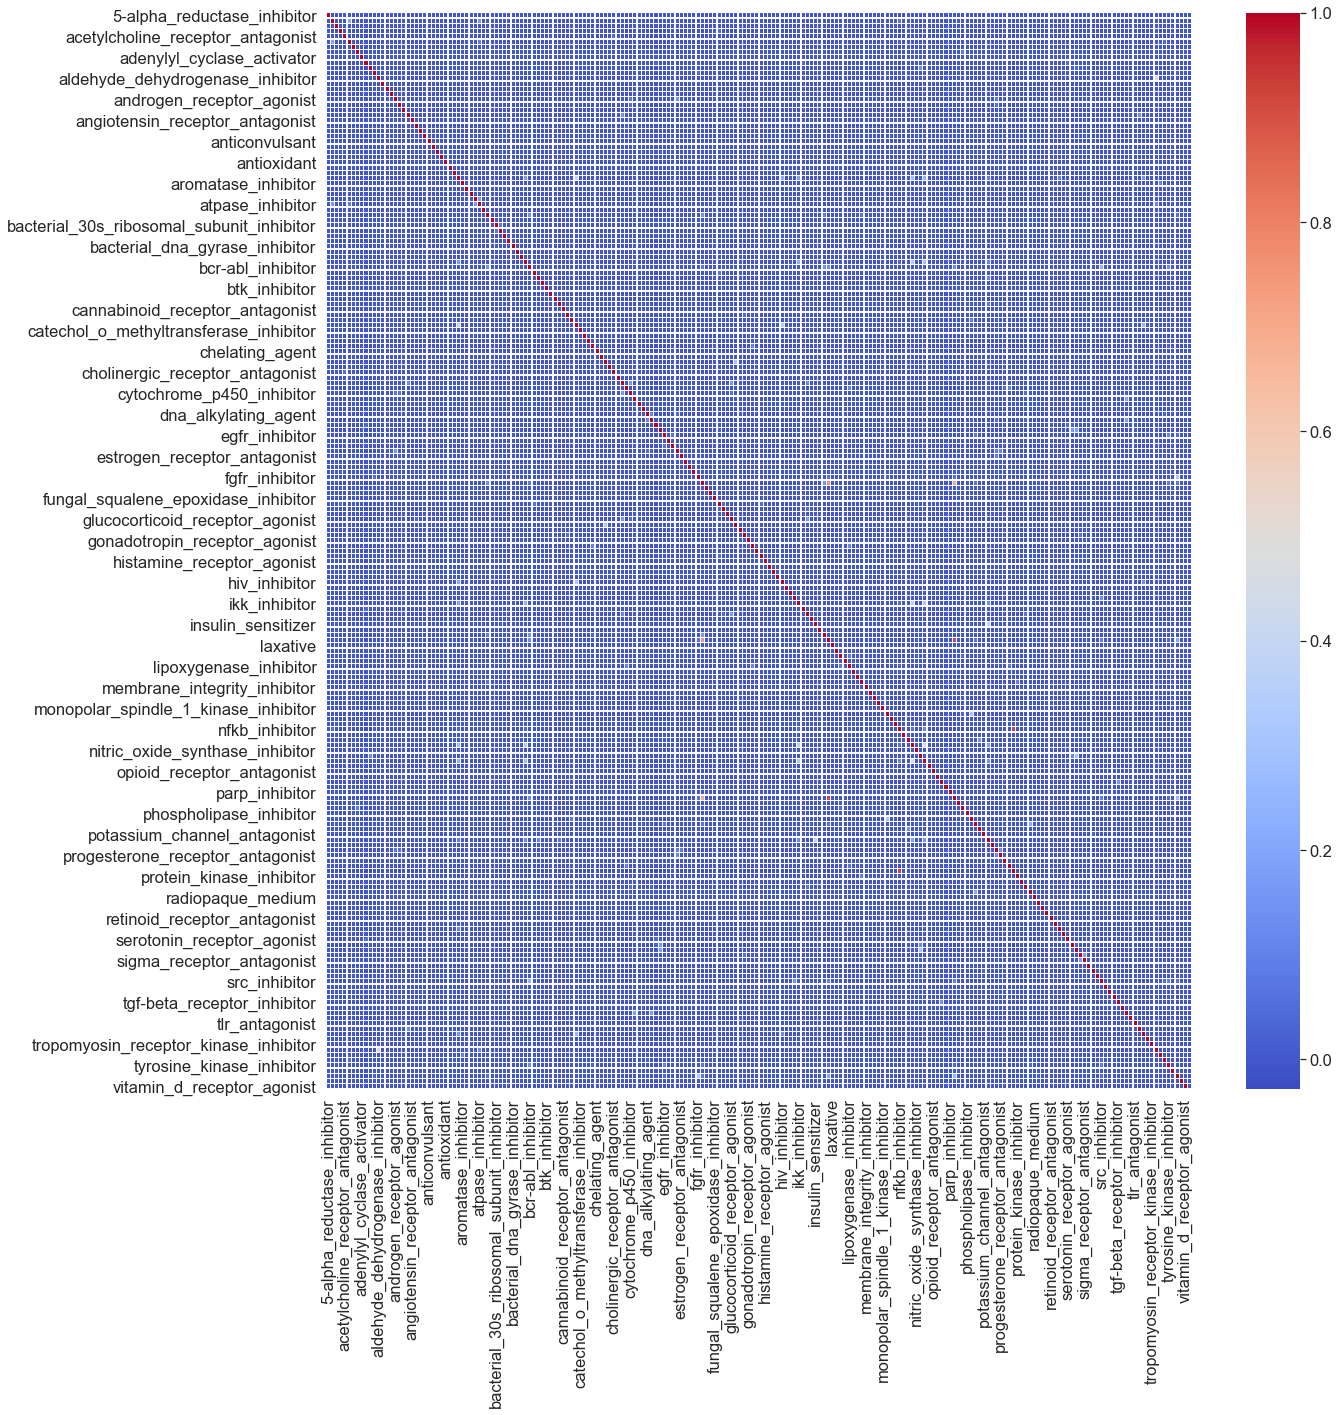

In [39]:
#Correlation between MoAs.
n = 10
db_variables = train_labels_without_control.drop(['sig_id', 'sum_MoA'], axis = 1).copy()
corr_matrix = db_variables.corr()
corr_table = corr_matrix.abs().unstack()
labels_to_drop = get_redundant_pairs(db_variables)
corr_table = corr_table.drop(labels = labels_to_drop).sort_values(ascending = False)
print("Top Absolute Correlations:")
print(corr_table[: n])
print()
print("Least Absolute Correlations:")
print(corr_table[len(corr_table) - n: ])
print()

size_x = 20     #This is a good size to visualise the heatmap saved as .png
size_y = 20
plt.figure(figsize = (size_x, size_y))
sns.set(font_scale = 1.5)

ax = sns.heatmap(corr_matrix, annot = False, linewidth = 0.2, cmap='coolwarm')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.tight_layout()
plt.savefig(path_analysis + 'MoA_correlation.png')

plt.show() 

We do not have so many mechanism of action correlated with another. This supports a strategy of one model per MoA.\
However, we still have some correlation, so it would be better to do only one model considering all MoA at the same time.\
The difference is that one model per MoA can be easily done using LightGBM or any other model like a Logit, but a multi label model with one observations being able to assume more than one classification demands a fancier model like a Feedforward neural network.